In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.utils.data import DataLoader, TensorDataset

# import os
# os.chdir("..")
import models as models
import utils as utils
import main as main
from logger import logger

from tqdm import tqdm
from scipy.ndimage import convolve1d

%load_ext autoreload
%autoreload

logger(".")

2025-04-02 00:33:04 | .


---

## Settings
---

In [26]:
class Settings:
    num = 1000
    load = False
    idx = 0
    use_bias = True
    
args = Settings()

if args.load:
    info, autoencoder = models.load_session(idx=args.idx)
    dim_ei = info['network_params']["dim_ei"]
    dim_ca3 = info['network_params']["dim_ca3"]
    dim_ca1 = info['network_params']["dim_ca1"]
    dim_eo = info['network_params']["dim_eo"]

    num_samples = info["num_stimuli"]

    K_lat = info['network_params']["K_lat"]
    beta = info['network_params']["beta"]
    K = info['network_params']["K"]

    # get parameters
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

    logger(f"{autoencoder=}")

    logger("<<< Loaded session >>>")
else:
    dim_ei = 50
    dim_ca3 = 50 
    dim_ca1 = 50
    dim_eo = dim_ei

    # data settings
    num_samples = 2000

    # model hyper-parameters
    K = 5
    K_lat = 15
    beta = 60

    # autoencoder
    autoencoder = models.Autoencoder(input_dim=dim_ei,
                                      encoding_dim=dim_ca1,
                                      activation=None,
                                      K=K_lat,
                                      beta=beta,
                                      use_bias=args.use_bias)
    logger(f"%Autoencoder: {autoencoder}")

2025-04-02 00:54:04 | %Autoencoder: Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
)


In [18]:
info['network_params'].keys()

dict_keys(['mec_N_x', 'mec_N_y', 'dim_mec', 'mec_sigma', 'dim_lec', 'num_cues', 'bias', 'dim_ei', 'dim_ca3', 'dim_ca1', 'dim_eo', 'K_lec', 'K_ei', 'K_ca3', 'K_ca1', 'K_eo', 'beta_ei', 'beta_ca3', 'beta_ca1', 'beta_eo', 'alpha'])

### training **AE** from scratch

#### Dataset

In [28]:

training_samples = utils.sparse_stimulus_generator(N=num_samples,
                                                   K=K,
                                                   size=dim_ei,
                                                   plot=False)
test_samples = utils.sparse_stimulus_generator(N=num_samples,
                                               K=K,
                                               size=dim_ei,
                                               plot=False)

# dataset for btsp
num_btsp_samples = args.num
training_sample_btsp = training_samples[np.random.choice(
                        range(training_samples.shape[0]),
                        num_btsp_samples, replace=False)]


logger("<<< Data generated >>>")

2025-04-02 00:54:16 | <<< Data generated >>>


In [134]:
""" AE training """

epochs = 400
loss_ae, autoencoder = utils.train_autoencoder(
                training_data=training_samples,
                test_data=test_samples,
                model=autoencoder,
                epochs=int(epochs),
                batch_size=10, learning_rate=1e-3)
logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")



Epoch [400], Loss: 0.0085, Test: 0.0369: 100%|█████████████████████████████████████████████████████████████| 400/400 [01:10<00:00,  5.69it/s]
2024-09-01 13:02:39 | <<< Autoencoder trained [loss=1.7057] >>>


2025-04-02 00:32:51 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=Truebeta=60, alpha=0.01, K_l=15, K_o=5
2025-04-02 00:32:51 | dataset 0, [tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]


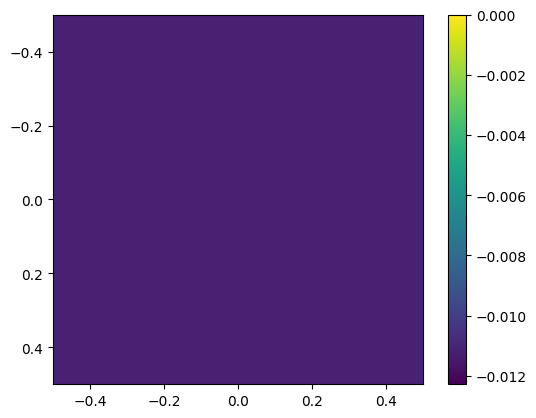

In [62]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            #lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                        model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

#### **AE** training

In [29]:
# train autoencoder
if not args.load:
    epochs = 2000
    loss_ae, autoencoder = utils.train_autoencoder(
                    training_data=training_samples,
                    test_data=test_samples,
                    model=autoencoder,
                    epochs=int(epochs),
                    batch_size=10, learning_rate=1e-3)
    logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")

# reconstruct data
out_ae, latent_ae = utils.reconstruct_data(data=training_sample_btsp,
                                            num=num_btsp_samples,
                                            model=autoencoder,
                                            show=False, 
                                            plot=False)

Epoch [2000], Loss: 0.0000, Test: 0.0107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:49<00:00,  4.26it/s]
2025-04-02 01:02:08 | <<< Autoencoder trained [loss=0.0024] >>>
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12312.69it/s]


In [7]:
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

## Sim 2
---
making the $\alpha$**-plot** training each pattern only once

#### attempt 1

In [31]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1, B_ca1_eo = None, None
    

#logger.debug(f"{W_ei_ca1.shape=}\n{type(W_ei_ca1)}")

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            #lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 2
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    loss_mtl, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=True,
                                progressive_test=True)
    #logger(f"<<< MTL trained [{loss_mtl:.3f}] >>>")

# reconstruct data
model.pause_lr()
out_mtl, latent_mtl = utils.reconstruct_data(
                                data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=model,
                                column=True,
                                plot=False)

#plt.imshow(loss_mtl, vmin=0)
#plt.colorbar();

2025-04-02 01:04:50 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=True, beta=60, alpha=0.01, K_l=15, K_o=5
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7338.27it/s]


#### attempt 2

2025-04-02 01:04:53 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=True, beta=60, alpha=0.01, K_l=15, K_o=5
2025-04-02 01:04:53 | dataset 0, [tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]])]


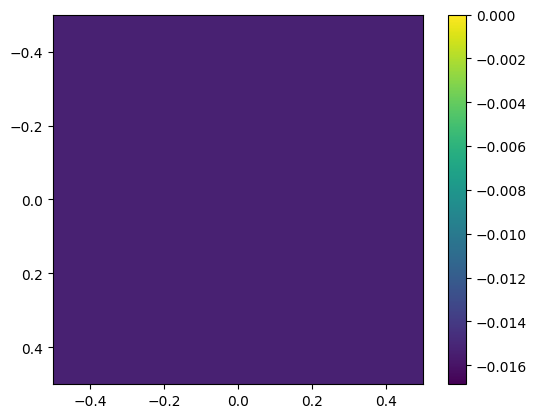

In [32]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
                    W_ca1_eo=W_ca1_eo,
                    B_ei_ca1=B_ei_ca1,
                    B_ca1_eo=B_ca1_eo,
                    dim_ca3=dim_ca3,
                    K_lat=K_lat,
                    K_out=K,
                    beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                        model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

In [25]:
training_sample_btsp.shape

(100, 50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 58.28it/s]


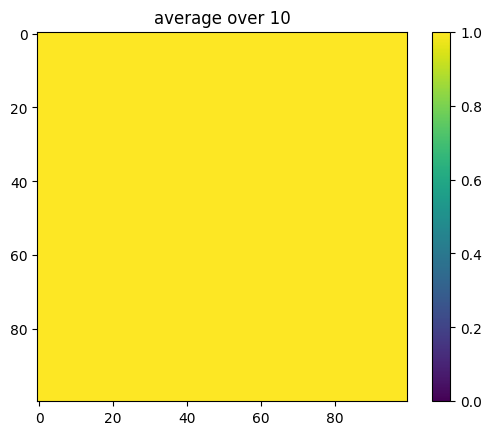

In [23]:
NUM_REP = 10

acc = np.zeros((args.num, args.num))
for _ in tqdm(range(NUM_REP)):
    model = models.MTL(W_ei_ca1=W_ei_ca1,
                W_ca1_eo=W_ca1_eo,
                B_ei_ca1=B_ei_ca1,
                B_ca1_eo=B_ca1_eo,
                dim_ca3=dim_ca3,
                K_lat=K_lat,
                K_out=K,
                beta=beta)
    
    #logger(f"%MTL: {model}")
    
    # train model | testing = training without backprop
    acc_epoch, _, = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=False,
                                progressive_test=True)

    acc += acc_epoch.numpy()
    
acc /= NUM_REP
plt.imshow(acc, vmin=0, vmax=1)
plt.title(f"average over {NUM_REP}")
plt.colorbar();

#### Plotting

NameError: name 'latent_mtl' is not defined

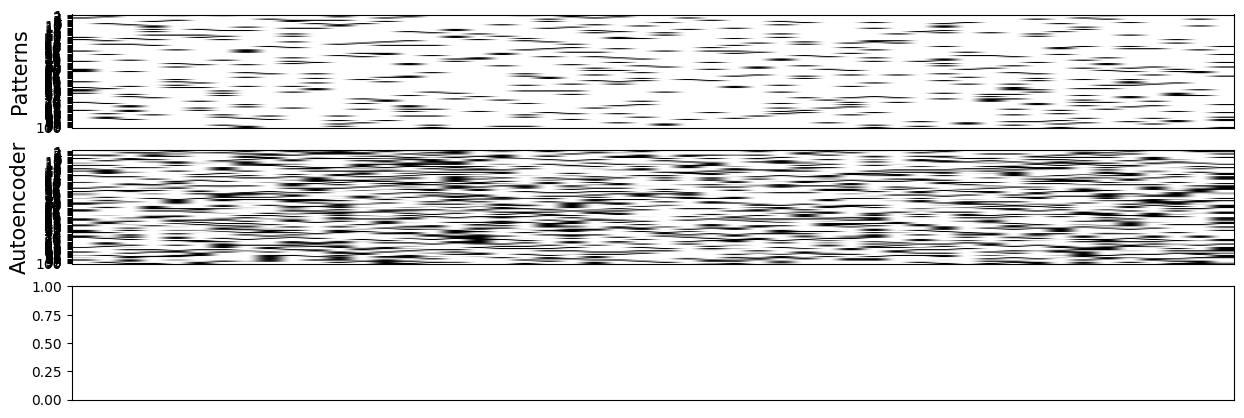

In [35]:
### """ plotting """

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax1,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=latent_ae, ax=ax2,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=latent_mtl, ax=ax3,
                         title="MTL", squash=is_squash)

fig.suptitle(f"Latent layers - $K_l=${K_lat} $\\beta=${autoencoder._beta}")

#
fig2, (ax12, ax22, ax32) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax12,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=out_ae, ax=ax22,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=out_mtl, ax=ax32,
                         title="MTL",
                         squash=is_squash)

fig2.suptitle(f"Data reconstruction of {num_btsp_samples} patterns - $K=${K} $\\beta=${autoencoder._beta}",
              fontsize=15)

#
fig3, (ax13) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
cbar = plt.colorbar(
    ax13.imshow(training_sample_btsp - out_mtl,
                cmap="seismic",
                aspect="auto"))
ax13.set_yticks(range(num_btsp_samples))

cbar.set_label("Error")
ax13.set_title("pattern - mtl")
plt.show()



In [36]:
plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

NameError: name 'loss_mtl' is not defined

## $\alpha$-plot
---
training of the MTL for different values of $\alpha$, and average over multiple repetitions

In [5]:
""" data """

num_samples = 200
num_rep = 1
datasets = []

stimuli = utils.sparse_stimulus_generator(N=num_samples,
                                          K=K,
                                          size=dim_ei,
                                          plot=False)

datasets = []
for k in range(num_samples):
    data = torch.tensor(stimuli[:k+1], dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data),
                            batch_size=1,
                            shuffle=False)
    datasets += [dataloader]

In [16]:
beta, alpha

(60, np.float64(1.0))

In [8]:
""" run """

num_alphas = 10
if num_alphas < 2:
    alphas = [0.4]
else:
    #alphas = [0.01, 0.04, 0.08, 0.2, 0.6, 1.]
    alphas = np.around(np.linspace(0.001, 1., num_alphas), 2)
    num_alphas = len(alphas)

outputs = np.zeros((num_rep, num_alphas, num_samples, num_samples))

for l in tqdm(range(num_rep)):
    for h, alpha in enumerate(alphas):

        # data
        stimuli = utils.sparse_stimulus_generator(N=num_samples,
                                                  K=K,
                                                  size=dim_ei,
                                                  plot=False)

        datasets = []
        for k in range(num_samples):
            data = torch.tensor(stimuli[:k+1], dtype=torch.float32)
            dataloader = DataLoader(TensorDataset(data),
                                    batch_size=1,
                                    shuffle=False)
            datasets += [dataloader]

        # run
        for i in tqdm(range(num_samples), disable=True):

            # make model
            model = models.MTL(W_ei_ca1=W_ei_ca1,
                        W_ca1_eo=W_ca1_eo,
                        B_ei_ca1=B_ei_ca1,
                        B_ca1_eo=B_ca1_eo,
                        dim_ca3=dim_ca3,
                        K_lat=K_lat,
                        K_ca3=10,
                        K_out=K,
                        beta=beta,
                        alpha=alpha)

            # train a dataset with pattern index 0.. i
            model.eval()
            with torch.no_grad():

                # one pattern at a time
                for batch in datasets[i]:
                    # forward
                    _ = model(batch[0].reshape(-1, 1))

            # test a dataset with pattern index 0.. i 
            model.pause_lr()
            model.eval()
            with torch.no_grad():
                # one pattern at a time
                for j, batch in enumerate(datasets[i]):
                    x = batch[0].reshape(-1, 1)

                    # forward
                    y = model(x)
                    # logger.debug(f"{x.shape}, {y.shape}")

                    # record : cosine similarity
                    # outputs[l, h, i, j] = (y.T @ x) / \
                    #     (torch.norm(x) * torch.norm(y))

                    value = (y.T @ x) / \
                        (torch.norm(x) * torch.norm(y))

                    outputs[l, h, i, j] = (value.item() - 0.2) / 0.8

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.66s/it]


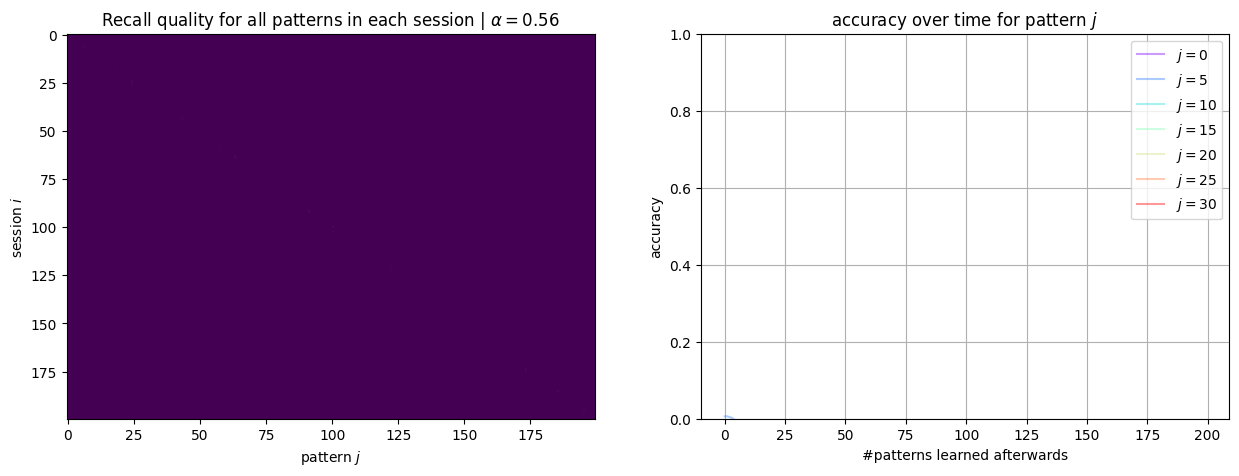

In [11]:
i = 5
outputs1 = outputs.mean(axis=0)[i]
# -> (sample, sample)

fig0 = plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(outputs1, cmap="viridis",
           vmin=0, vmax=1, aspect="auto")
plt.title(f"Recall quality for all patterns in each session | $\\alpha=${alphas[i]}")
plt.xlabel("pattern $j$")
plt.ylabel("session $i$")


plt.subplot(122)
# plt.axhline(0.1, color="r", linestyle="--",
#             alpha=0.2)
# smoothing
num_p = 7
jumps = 5
colors = plt.cm.rainbow(np.linspace(0, 1, num_p))
for di, d in enumerate(range(0, jumps*num_p, jumps)):
    output_d = outputs1[d:, d] # selection of one pattern
    nsmooth = 30
    padded_d = np.pad(output_d, (nsmooth-1, 0), mode="edge")
    output_d = np.convolve(padded_d,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
    plt.plot(output_d, '-', label=f"$j=${d}", alpha=0.4,
             color=colors[di])

plt.ylim(0., 1)
plt.ylabel("accuracy")
plt.xlabel("#patterns learned afterwards")
plt.legend()
plt.title("accuracy over time for pattern $j$")
plt.grid()

plt.show()

#### Plot

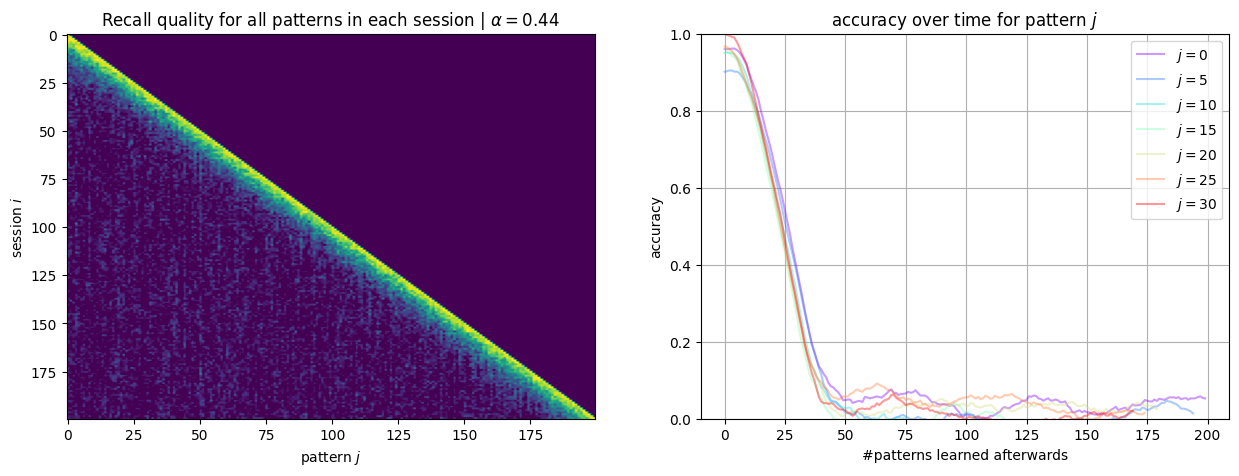

In [11]:
i = 4
outputs1 = outputs.mean(axis=0)[i]
# -> (sample, sample)

fig0 = plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(outputs1, cmap="viridis",
           vmin=0, vmax=1, aspect="auto")
plt.title(f"Recall quality for all patterns in each session | $\\alpha=${alphas[i]}")
plt.xlabel("pattern $j$")
plt.ylabel("session $i$")


plt.subplot(122)
# plt.axhline(0.1, color="r", linestyle="--",
#             alpha=0.2)
# smoothing
num_p = 7
jumps = 5
colors = plt.cm.rainbow(np.linspace(0, 1, num_p))
for di, d in enumerate(range(0, jumps*num_p, jumps)):
    output_d = outputs1[d:, d] # selection of one pattern
    nsmooth = 30
    padded_d = np.pad(output_d, (nsmooth-1, 0), mode="edge")
    output_d = np.convolve(padded_d,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
    plt.plot(output_d, '-', label=f"$j=${d}", alpha=0.4,
             color=colors[di])

plt.ylim(0., 1)
plt.ylabel("accuracy")
plt.xlabel("#patterns learned afterwards")
plt.legend()
plt.title("accuracy over time for pattern $j$")
plt.grid()

plt.show()

## Memory capacity

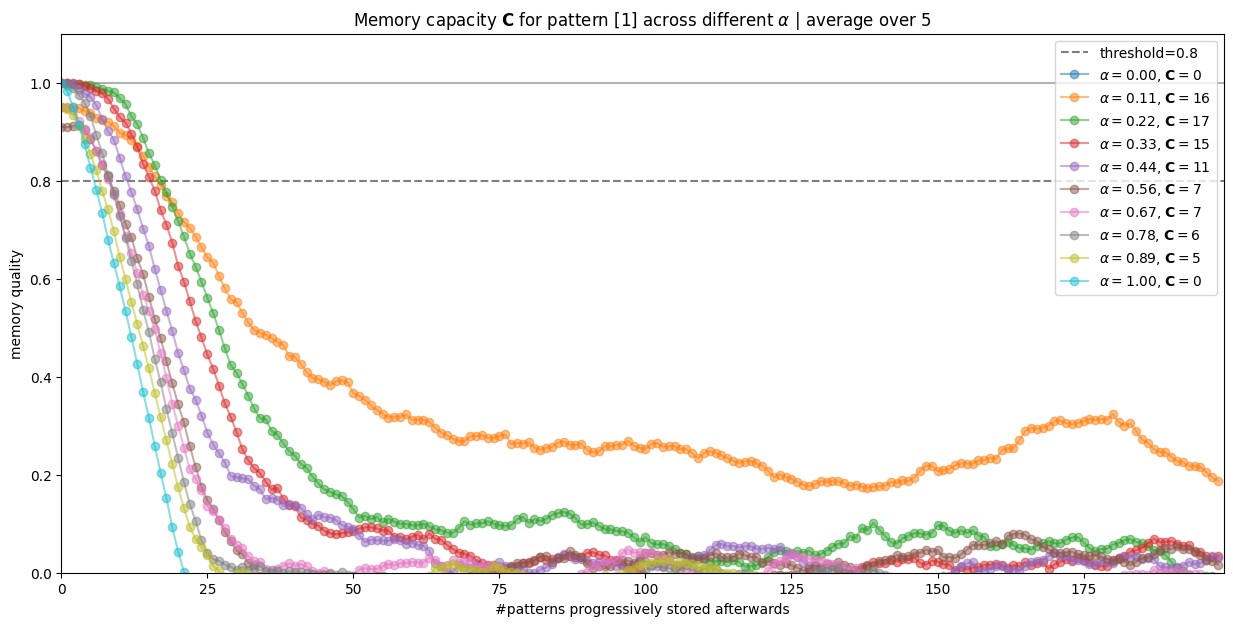

In [17]:
threshold = 0.8
idx_pattern = 1
nsmooth = 20
tot = outputs.shape[-1]

fig1 = plt.figure(figsize=(15, 7))
plt.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
plt.axhline(1., color="black", alpha=0.3)
#plt.axvline(idx_pattern, color="black", alpha=0.3)


for i, out in enumerate(outputs.mean(axis=0)):
    out = out[idx_pattern:]

    # calculate the memory capacity
    capacity = utils.calc_capacity(outputs=out,
                                   threshold=threshold,
                                   nsmooth=nsmooth,
                                   idx_pattern=idx_pattern)

    # smooth
    padded_out = np.pad(out[:, idx_pattern],
                        (nsmooth-1, 0), mode="edge")
    out = np.convolve(padded_out,
                      np.ones(nsmooth)/nsmooth,
                      mode="valid")

    
    plt.plot(range(len(out)), out, 'o-', alpha=0.5, label=f"$\\alpha=${alphas[i]:.2f}, $\mathbf{{C}}=${capacity}")
plt.ylim(0, 1.1)
plt.ylabel("memory quality")
plt.xlim(0, len(out))
plt.xlabel("#patterns progressively stored afterwards")
plt.legend(loc="upper right")
plt.title(f"Memory capacity $\mathbf{{C}}$ for pattern [{idx_pattern}] across different $\\alpha$ | average over {num_rep}")
#plt.grid()
plt.show()

In [14]:
model

MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=True, lr=0.0,beta=60, alpha=1.0, K_l=15, K_o=5

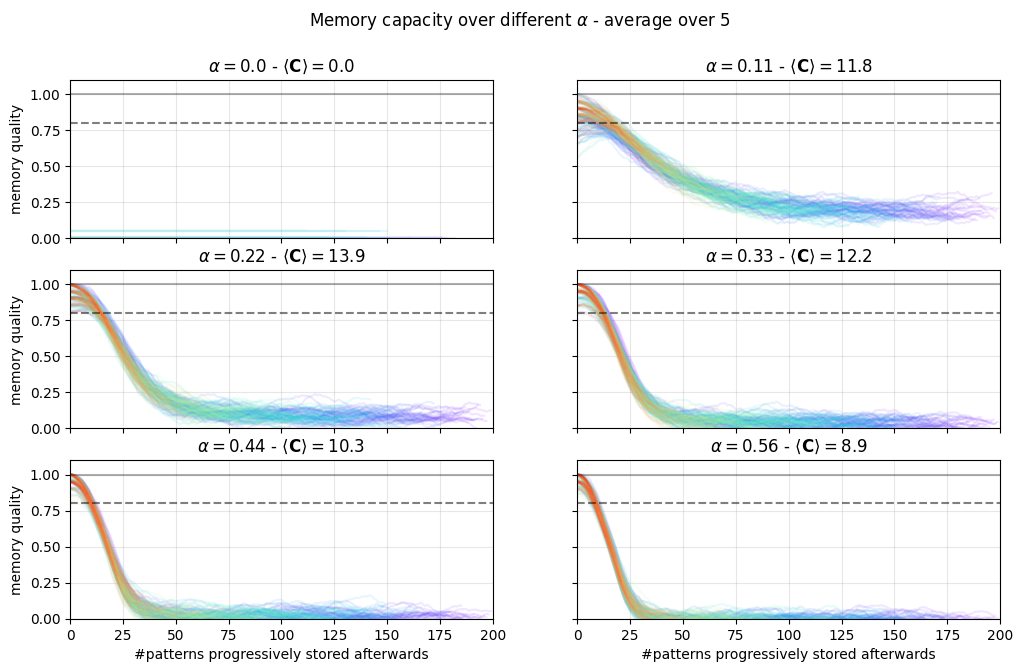

In [18]:
threshold = 0.8
nsmooth = 20
tot = outputs.shape[-1]

fig, axs = plt.subplots(3, 2, figsize=(12, 7), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle(f"Memory capacity over different $\\alpha$ - average over {num_rep}")
ia = 0
colors = plt.cm.rainbow(np.linspace(0, 1, tot))  # starts at purple

outs = outputs.mean(axis=0)

for k, ax in enumerate(axs):
    C = 0
    for i in range(tot):
            
        # calculate the memory capacity
        capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=i)
        C += capacity
    
        # smooth
        padded_out = np.pad(outs[k, i:, i],
                            (nsmooth-1, 0), mode="edge")
        out = np.convolve(padded_out,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
        
        ax.plot(range(len(out)), out, '-', alpha=0.1, color=colors[i])#, label=f"$i=${i}, $\mathbf{{C}}=${capacity}")

    ax.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
    ax.axhline(1., color="black", alpha=0.3)
    ax.set_ylim(0, 1.1)       
    ax.grid(alpha=0.3)
    #ax.legend()
    if k % 2 == 0:
        ax.set_ylabel("memory quality")
    ax.set_xlim(0, tot)
    if k > 3:
        ax.set_xlabel("#patterns progressively stored afterwards")

    ax.set_title(f"$\\alpha=${alphas[k]} - $\\langle \\mathbf{{C}}\\rangle=${C/tot:.1f}")
#plt.grid()
plt.show()

---

#### make animation

In [165]:
from IPython.display import Image
from IPython.display import clear_output
import imageio.v2 as imageio
import time

CACHE_PATH = "../media/cache/"
OBS_PATH = "../media/"


class AnimationMaker:

    def __init__(self, **kwargs):

        """
        Parameters
        ----------
        kwargs : dict
            fps : int
                frames per second, default=10
            use_logger : bool
                use logger, default=True
            path : str
                alternative path to save the animation, default=CACHE_PATH
        """

        self._use_logger = kwargs.get("use_logger", True)
        # self._path = kwargs.get("path", path_dict['cache'])
        self._path = kwargs.get("path", CACHE_PATH)
        self._fps = kwargs.get("fps", 10)
        self._saved_frames = []

        self.anim_name = ""
        self._are_frames = False
        self._is_animation = False

        self._hash = str(np.random.random())[3:10]

        if self._use_logger:
            logger.info(f'AnimationMaker: path={self._path}')

    def add_frame(self, fig: plt.Figure):

        """
        save figure to cache
        
        Parameters
        ----------
        fig : object
            matplotlib.figure.Figure
        """

        name = f"figure_{len(self._saved_frames)}_{self._hash}.png"
        fig.savefig(os.path.join(self._path, f"{name}"), dpi=300)

        self._saved_frames.append(name)

        if not self._are_frames:
            self._are_frames = True

    def delete_frames(self):

        """
        delete all saved figures
        """

        for name in self._saved_frames:
            os.remove(os.path.join(self._path, name))

        self._saved_frames = []
        self._are_frames = False

    def make_animation(self, name: str):

        """
        make animation from saved figures
        
        Parameters
        ----------
        name : str
            name of the animation
        """

        # there should be frames to make animation
        if not self._are_frames:
            logger.warning("!AnimationMaker: no frames to make animation")
            return

        if self._use_logger:
            logger.info(f"AnimationMaker: making animation ({len(self._saved_frames)} frames) ...")

        # create animation
        # with imageio.get_writer(os.path.join(self._path, f'{name}.gif'), mode='I', fps=fps) as writer:
        #     for name in self._saved_frames:
        #         writer.append(imageio.imread(os.path.join(self._path, name)))
        anim = []
        for fig_name in tqdm(self._saved_frames):
            anim += [imageio.imread(os.path.join(self._path, fig_name))]

        imageio.mimsave(os.path.join(self._path, f'{name}.gif'), anim, fps=self._fps)

        self.anim_name = name
        self._is_animation = True

        # delete figures
        self.delete_frames()

        if self._use_logger:
            logger.info(f'AnimationMaker: animation {name}.gif created')

    def save_animation(self, path: str=OBS_PATH, name: str=None, use_timestamp: bool=True):

        """
        save the animation gif in the new path

        Parameters
        ----------
        path : str
            path to save the animation, default=OBS_PATH
        name : str
            name of the animation, default=None
        use_timestamp : bool
            use timestamp in the name, default=True
        """

        if not self._is_animation:
            logger.warning('!AnimationMaker: no animation to save')
            return


        name = name if name is not None else self.anim_name

        if use_timestamp:
            timestamp = generate_timestamp()
            name = f'{timestamp}_{name}'

        # animation current path 
        anim_path = os.path.join(self._path, f'{name}.gif')

        # target path 
        # path = os.path.join(path, f'{self.anim_name}.gif')

        # move animation.gif to new path
        os.system(f"mv {anim_path} {path}")      # anim = imageio.mimread(os.path.join(self._path, f'{self.anim_name}.gif'))

        # # save in new path 
        # imageio.mimsave(os.path.join(path, f'{self.anim_name}.gif'), anim)

        # # delete old anim
        # os.remove(os.path.join(self._path, f'{self.anim_name}.gif'))

        if self._use_logger:
            logger.info(f'AnimationMaker: animation {self.anim_name}.gif saved in {path}')

    def delete_animation(self):

        """
        delete the animation
        """

        if not self._is_animation:
            logger.warning('!AnimationMaker: no animation to delete')
            return

        os.remove(os.path.join(self._path, f'{self.anim_name}.gif'))

        self._is_animation = False

        if self._use_logger:
            logger.info(f'AnimationMaker: animation {self.anim_name}.gif deleted')

    def play_animation(self, **kwargs) -> Image:

        """
        play the animation

        Parameters
        ----------
        kwargs : dict
            return_Image : bool
                return the animation as Image object, default False

        Returns
        -------
        Image : object
            IPython.display.Image
        """

        # there should be an animation to play
        if not self._is_animation:
            logger.warning('!AnimationMaker: no animation to play')
            return

        # play anim
        if kwargs.get("return_Image", False):
            return Image(open(os.path.join(self._path, f'{self.anim_name}.gif'), 'rb').read(),
                     width=kwargs.get('width', 500),
                     height=kwargs.get('height', 500))

        os.system(f"open {os.path.join(self._path, f'{self.anim_name}.gif')} -a Brave")

2024-09-02 19:37:27 | AnimationMaker: path=media/
2024-09-02 19:37:33 | AnimationMaker: making animation (20 frames) ...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.25it/s]
2024-09-02 19:37:35 | AnimationMaker: animation rcapacities_193733.gif created


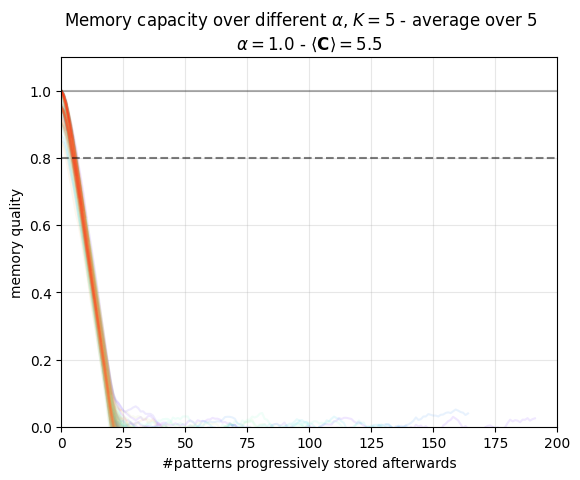

In [174]:
threshold = 0.8
nsmooth = 20
tot = outputs.shape[-1]
#alphas = [0.01, 0.04, 0.08, 0.2, 0.6, 1.]

fig, ax = plt.subplots()
fig.suptitle(f"Memory capacity over different $\\alpha$, $K=${K} - average over {num_rep}")
animation_maker = AnimationMaker(fps=3,
                                 use_logger=True,
                                 path=r"media/")


ia = 0
colors = plt.cm.rainbow(np.linspace(0, 1, tot))  # starts at purple

outs = outputs.mean(axis=0)
Cs = []

for k in range(len(alphas)):
    C = 0
    ax.clear()
    for i in range(tot):
            
        # calculate the memory capacity
        capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=i)
        C += capacity
    
        # smooth
        padded_out = np.pad(outs[k, i:, i],
                            (nsmooth-1, 0), mode="edge")
        out = np.convolve(padded_out,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
        
        ax.plot(range(len(out)), out, '-', alpha=0.1, color=colors[i])#, label=f"$i=${i}, $\mathbf{{C}}=${capacity}")

    Cs += [C/tot]
    ax.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
    ax.axhline(1., color="black", alpha=0.3)
    ax.set_ylim(0, 1.1)       
    ax.grid(alpha=0.3)
    #ax.legend()
    ax.set_ylabel("memory quality")
    ax.set_xlim(0, tot)
    ax.set_xlabel("#patterns progressively stored afterwards")

    ax.set_title(f"$\\alpha=${alphas[k]} - $\\langle \\mathbf{{C}}\\rangle=${C/tot:.1f}")
    animation_maker.add_frame(fig)

#
animation_maker.make_animation(
    name=f"rcapacities_{time.strftime('%H%M%S')}")

animation_maker.play_animation(return_Image=False)

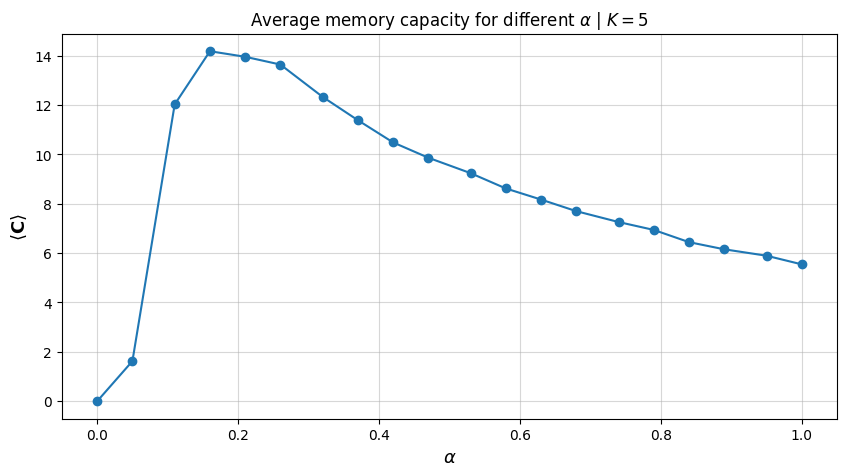

In [179]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(alphas, Cs, 'o-')

#plt.ylim((0, 5))
ax.set_ylabel("$\\langle\mathbf{C}\\rangle$", fontsize=13)
ax.set_xlabel("$\\alpha$", fontsize=13)
ax.set_title(f"Average memory capacity for different $\\alpha$ | $K=${K}")
ax.grid(alpha=0.5)
plt.show()

In [156]:
capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=None)
capacity

ValueError: object too deep for desired array

## 1D linear track

#### utils

In [4]:
def sparse_stimulus_generator_sensory(num_stimuli: int, K : int,
                                      mec_size: int,  lec_size: int,
                                      N_x : int, N_y : int,
                                      pf_sigma: int,
                                      num_laps: int,
                                      cue_duration: int=1,
                                      lap_length: int=None,
                                      num_cues: int=None,
                                      position_list=None,
                                      cue_positions=None,
                                      sen_list=None,
                                      plot: bool=False,
                                      sigma: float=5) -> np.ndarray:

    """
    This function generates random z patterns with a certain
    degree of sparsity

    Parameters
    ----------
    N : int
        Number of samples
    K : int
        Number of active units
    size : int, optional
        Size of the z patterns, by default 10
    plot : bool, optional
        Whether to plot the z patterns.
        Default False

    Returns
    -------
    samples : np.ndarray
        z patterns
    """

    def place_field_activity(N_x, N_y, sigma, xi, yi):
        """
        Computes place field activity for each cell on an NxN grid for a given location (xi, yi).
        """

        def circular_distance(x1, x2, N):
            """
            Computes the minimum circular distance in the x-direction (wraps around the boundaries).
            """
            return np.minimum(np.abs(x1 - x2), N - np.abs(x1 - x2))

        # Create a grid of size NxN with place cells at each position
        x = np.linspace(0, N_x-1, N_x)
        y = np.linspace(0, N_y-1, N_y)
        X, Y = np.meshgrid(x, y)
        # Calculate the squared Euclidean distance between (xi, yi) and each place cell location
        dist_squared = circular_distance(X, xi, N_x) ** 2 + (Y - yi) ** 2

        # Compute Gaussian activity for each place cell
        activity = np.exp(-dist_squared / (2 * sigma ** 2))
        return activity

    def pc_cue_probability(x, c, sigma):
        p = np.exp(-((x - c) ** 2) / (2 * sigma ** 2))
        return np.random.binomial(1, p)

    samples = np.zeros((num_stimuli, mec_size + lec_size))
    alpha_samples = np.zeros(num_stimuli)

    #cue_pattern_size = lec_size//num_cues  # 
    if lec_size > 0 and num_cues is not None:
        fixed_cue = np.zeros((num_cues, lec_size))
        for k in range(num_cues):
            cue_idx = np.random.choice(range(lec_size), replace=False, size=K)
            #fixed_cue[cue_idx] = 1
            fixed_cue[k, K*k: K*(k+1)] = 1  # | 1, 1, .0s  , 1, 1, ..0s.. |

    # 0, 0, 1, 0, 1, 1...
    #lap_cues = np.random.choice(range(num_cues), size=num_laps) if num_laps is not None else None
    lap_cues = np.zeros(num_laps) if position_list is not None else None
    
    position_pool = np.arange(N_x)  # Possible positions in 1D track

    """
    [0, 1, 3, 4.. 10, 0, 1, 3, ...10]
    """
    lap_i = 0
    for i in range(num_stimuli): # laps x length

        if cue_positions is not None:

            # count laps
            if i % lap_length == 0:
                print("---------------------------")
                lap_idx = (lap_i // cue_duration) % num_cues
                lap_cues[lap_i] = lap_idx

                print(f"lap {lap_i}, cue {lap_idx}")
                lap_i += 1
            
        """
        if mec_size > 0:
            x_i, y_i = (position_list[i] if position_list is not None \
                                else (np.random.randint(0, N_x), np.random.randint(0, N_y)))
            activity_grid = place_field_activity(N_x, N_y, pf_sigma, x_i, y_i)
            samples[i, :mec_size] = activity_grid.flatten()

        """
        if mec_size > 0:
            # Reset the pool every 50 samples
            if position_list is None:
              if i % mec_size == 0:
                  np.random.shuffle(position_pool)  # Shuffle the pool to get random order
              pos_idx = i % 50  # Get position index within the shuffled pool
              x_i = position_pool[pos_idx]  # Choose the x position
              y_i = np.random.randint(0, N_y)
            else:
              x_i, y_i = position_list[i]
            activity_grid = place_field_activity(N_x, N_y, pf_sigma, x_i, y_i)
            samples[i, :mec_size] = activity_grid.flatten()        

        if lec_size > 0:
            
            # cue positions provided
            if cue_positions is not None:
                #p = samples[i, cue_positions[lap_cues[lap_idx]]] / \
                p = samples[i, cue_positions[lap_idx]] / \
                    samples[i, :mec_size].max()
                alpha_samples[i] = p

                if np.random.binomial(1, p):
                    activity_lec = fixed_cue[lap_cues[lap_idx].astype(int)]
                else:
                    #activity_lec = np.zeros((lec_size))
                    #lec_idx = np.random.choice(range(lec_size),
                    #                           replace=False, size=K)
                    #activity_lec[lec_idx] = 1

                    activity_lec = np.zeros((lec_size))
                    lec_idx = np.random.choice(range(lec_size),
                                               replace=False, size=K)
                    activity_lec[lec_idx] = 1
            else:
                
                if cue_positions is not None:
                    lec_idx = np.random.choice(range(lec_size),
                                               replace=False, size=K)
                    activity_lec[lec_idx] = 1
                    
                else:
                    activity_lec = np.zeros((lec_size))
                    lec_idx = np.random.choice(range(lec_size),
                                           replace=False, size=K)
                    activity_lec[lec_idx] = 1


            samples[i, mec_size:] = sen_list[i] if sen_list is not None else activity_lec
            
    samples = samples.astype(np.float32) # [ 00000 |      ]

    return samples, lap_cues, alpha_samples



def get_track_input(tp: dict, network_params: dict, cue_duration: int=1):

  position_list = [(x, 0) for lap in range(tp["num_laps"]) for x in range(tp["length"])]

  if tp["reward"] == "random":
    reward_list = None
  if tp["cue"] == "random":
    cue_list = None

  sen_list = None

  track_input, lap_cues, alpha_samples = sparse_stimulus_generator_sensory(num_stimuli=tp["num_laps"]*tp["length"],
                                                  K = network_params["K_lec"],
                                                  mec_size=network_params["dim_mec"],
                                                  lec_size=network_params["dim_lec"],
                                                  N_x=network_params["mec_N_x"],
                                                  N_y=network_params["mec_N_y"],
                                                  cue_duration=cue_duration,
                                                  pf_sigma=network_params["mec_sigma"],
                                                  lap_length=track_params["length"],
                                                  num_laps=track_params["num_laps"],
                                                  num_cues=network_params["num_cues"],
                                                  position_list=position_list,
                                                  cue_positions=tp["cue_position"],
                                                  sen_list=None,
                                                  plot=False)
  return track_input, lap_cues, alpha_samples

logger

2025-03-30 19:45:35 | .


In [3]:
def testing_mod(data: np.ndarray, model: object,
                   alpha_samples: np.ndarray,
                   alpha_baseline: float=0.1,
                   criterion: object=MSELoss(),
                   column: bool=False,
                   use_tensor: bool=False,
                   progressive_test: bool=False):

    """
    Test the model

    Parameters
    ----------
    data: np.ndarray
        z data
    model: nn.Module
        the model
    """

    if not isinstance(data, DataLoader):
        # Convert numpy array to torch tensor
        data_tensor = torch.tensor(data, dtype=torch.float32)

        # Create a dataset and data loader
        dataset = TensorDataset(data_tensor)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    else:
        dataloader = data

    if use_tensor:
        try:
            data_tensor
        except NameError:
            raise ValueError("data_tensor is not defined")
        dataloader = data_tensor.unsqueeze(1)

    # Set the model to evaluation mode
    model.eval()
    loss = 0.
    acc_matrix = torch.zeros(len(dataloader), len(dataloader))

    alpha = model._alpha
    logger("testing...")

    with torch.no_grad():

        for i, batch in utils.tqdm_enumerate(dataloader):
            x = batch[0] if not column else batch[0].reshape(-1, 1)

            new_alpha = np.maximum(alpha_baseline, alpha * alpha_samples[i])

            # Forward pass
            model.set_alpha(alpha=new_alpha)
            outputs = model(x)  # MTL training BTSP
            loss += criterion(outputs, x)

    model.train()

    return loss / len(dataloader), model

logger

2024-10-15 22:37:35 | .


#### settings

In [2]:
network_params = {}

network_params["mec_N_x"] = 50
network_params["mec_N_y"] = 1
network_params["dim_mec"] = network_params["mec_N_x"]*network_params["mec_N_y"]
network_params["mec_sigma"] = 4
network_params["dim_lec"] = 50
network_params["num_cues"] = 2
NUM_CUES = network_params["num_cues"]

network_params["bias"] = False

network_params["dim_ei"] = network_params["dim_mec"] + network_params["dim_lec"]
network_params["dim_ca3"] = 1000
network_params["dim_ca1"] = 1000
network_params["dim_eo"] = network_params["dim_ei"]

network_params["K_lec"] = 5
network_params["K_ei"] = 10
network_params["K_ca3"] = 15#15
network_params["K_ca1"] = 15#15
network_params["K_eo"] = network_params["K_ei"]

network_params["beta_ei"] = 150
network_params["beta_ca3"] = 150
network_params["beta_ca1"] = 150
network_params["beta_eo"] = network_params["beta_ei"]

""" track parameters """
track_params = {}
track_params["length"] = network_params["mec_N_x"]
track_params["num_laps"] = 100
track_params["reward"] = "random"
track_params["cue"] = "random"
NUM_LAPS = track_params["num_laps"]

logger

2025-03-30 19:45:23 | .


#### autoencoder

In [5]:
""" make data """

num_train_stimuli = 500
num_test_stimuli = 500

training_samples, _, _ = sparse_stimulus_generator_sensory(num_stimuli=num_train_stimuli,
                                                K = network_params["K_lec"],
                                                mec_size=network_params["dim_mec"],
                                                lec_size=network_params["dim_lec"],
                                                N_x=network_params["mec_N_x"],
                                                N_y=network_params["mec_N_y"],
                                                pf_sigma=network_params["mec_sigma"],
                                                lap_length=track_params["length"],
                                                num_laps=None,#track_params["num_laps"],
                                                num_cues=None,#network_params["num_cues"],
                                                position_list=None,
                                                cue_positions=None,
                                                sen_list=None,
                                                plot=False)

test_samples, _, _ = sparse_stimulus_generator_sensory(num_stimuli=num_test_stimuli,
                                                K = network_params["K_lec"],
                                                mec_size=network_params["dim_mec"],
                                                lec_size=network_params["dim_lec"],
                                                N_x=network_params["mec_N_x"],
                                                N_y=network_params["mec_N_y"],
                                                pf_sigma=network_params["mec_sigma"],
                                                lap_length=track_params["length"],
                                                num_laps=None,#track_params["num_laps"],
                                                num_cues=None,#network_params["num_cues"],
                                                position_list=None,
                                                cue_positions=None,
                                                sen_list=None,
                                                plot=False)
logger

2025-03-30 19:45:40 | .


In [6]:
""" initialization """

# autoencoder
autoencoder = models.Autoencoder(input_dim=network_params["dim_ei"],
                                 encoding_dim=network_params["dim_ca1"],
                                 K=network_params["K_ca1"],
                                 beta=network_params["beta_ca1"],
                                 use_bias=network_params["bias"])
logger(f"%Autoencoder: {autoencoder}")
  
""" run """
epochs = 500
loss_ae, autoencoder = utils.train_autoencoder(
                training_data=training_samples,
                test_data=test_samples,
                model=autoencoder,
                epochs=int(epochs),
                batch_size=64, learning_rate=1e-3)

loss_ae, autoencoder = utils.train_autoencoder(
                training_data=training_samples,
                test_data=test_samples,
                model=autoencoder,
                epochs=int(epochs),
                batch_size=64, learning_rate=5e-4)

2025-03-30 19:45:42 | %Autoencoder: Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=1000, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=False)
  )
)
Epoch [500], Loss: 0.0000, Test: 0.0244: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.94it/s]


In [6]:
# --- load autoencoder
info, autoencoder = models.load_session(
    idx=0, verbose=True)


out_ae, latent_ae = utils.reconstruct_data(
                                data=training_samples,
                                num=10,
                                model=autoencoder,
                                show=False, 
                                plot=False)


2024-10-15 22:37:42 | Pre-selected session: [0]
2024-10-15 22:37:42 | bias=False
/Users/daniekru/Research/lab/KAMemory/src/models.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

{'date': '15/10/2024 15:54:40',
 'epochs': 1000,
 'loss_ae': 0.00051,
 'network_params': {'K_ca1': 25,
                    'K_ca3': 25,
                    'K_ei': 10,
                    'K_eo': 10,
                    'K_lec': 5,
                    'alpha': 0.5,
                    'beta_ca1': 150,
                    'beta_ca3': 150,
                    'beta_ei': 150,
                    'beta_eo': 150,
                    'bias': False,
                    'dim_ca1': 1000,
                    'dim_ca3': 1000,
                    'dim_ei': 100,
                    'dim_eo': 100,
                    'dim_lec': 50,
                    'dim_mec': 50,
                    'mec_N_x': 50,
                    'mec_N_y': 1,
                    'mec_sigma': 4,
                    'num_cues': 2},
 'num_stimuli': 1000}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 1630.00it/s]


#### model

In [37]:
""" initialization """
network_params["alpha"] = 0.5
alpha_baseline = 0.1
network_params["num_cues"] = 2
track_params["cue_position"] = [10, 30]
track_params["num_laps"] = 100


track_train_input, lap_cues, alpha_samples = get_track_input(tp=track_params,
                                                             network_params=network_params,
                                                             cue_duration=1)
logger(f"shape: {track_train_input.shape} {lap_cues.shape}")

2024-10-15 22:43:11 | shape: (5000, 100) (100,)


---------------------------
lap 0, cue 0
---------------------------
lap 1, cue 1
---------------------------
lap 2, cue 0
---------------------------
lap 3, cue 1
---------------------------
lap 4, cue 0
---------------------------
lap 5, cue 1
---------------------------
lap 6, cue 0
---------------------------
lap 7, cue 1
---------------------------
lap 8, cue 0
---------------------------
lap 9, cue 1
---------------------------
lap 10, cue 0
---------------------------
lap 11, cue 1
---------------------------
lap 12, cue 0
---------------------------
lap 13, cue 1
---------------------------
lap 14, cue 0
---------------------------
lap 15, cue 1
---------------------------
lap 16, cue 0
---------------------------
lap 17, cue 1
---------------------------
lap 18, cue 0
---------------------------
lap 19, cue 1
---------------------------
lap 20, cue 0
---------------------------
lap 21, cue 1
---------------------------
lap 22, cue 0
---------------------------
lap 23, cue 1
--

In [38]:
""" make model """
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(
                                                        bias=network_params["bias"])

model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=network_params["dim_ca3"],
            K_lat=network_params["K_ca1"],
            K_out=network_params["K_eo"],
            K_ca3=network_params["K_ca3"],
            beta=network_params["beta_ca1"],
            alpha=network_params["alpha"],
            identity_IS=False,
            random_IS=False)

""" run """
_, model = testing_mod(data=track_train_input,
                       model=model,
                       alpha_samples=alpha_samples,
                       alpha_baseline=alpha_baseline,
                       column=True)

logger

2024-10-15 22:43:13 | testing...
100%|████████████████████████████████████████| 5000/5000 [00:11<00:00, 449.84it/s]
2024-10-15 22:43:24 | .


**CA3**

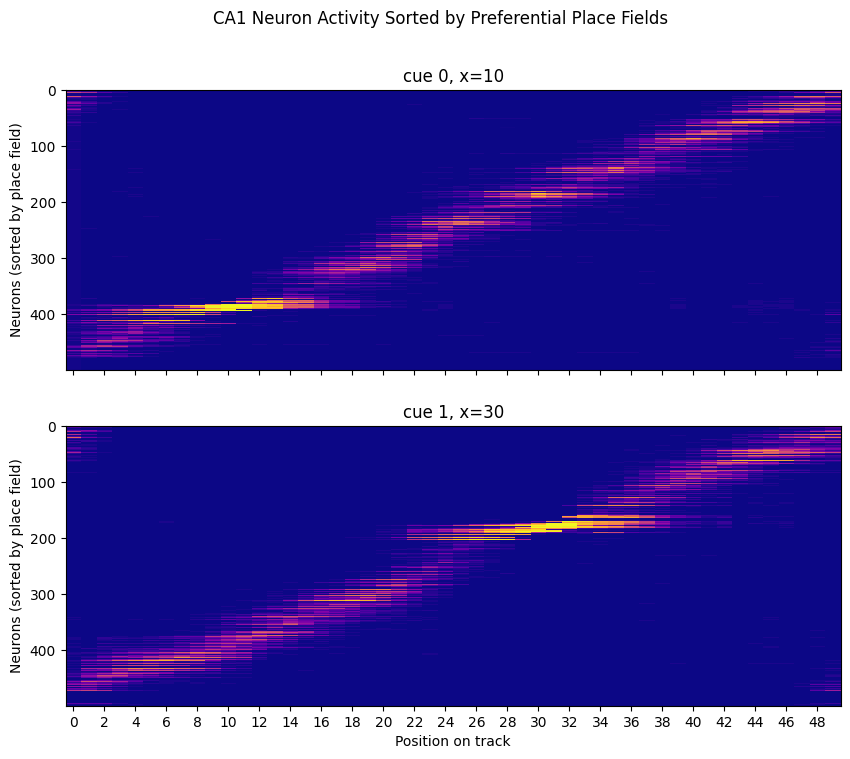

In [39]:
""" plot """
name="ca1"
activity = np.array(model.recordings[name]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))


# Assuming 'activity' is a 3D array of shape (laps, positions, neurons)
# activity.shape = (n_laps, n_positions, n_neurons)



# Step 4: Plot the heatmap
_, axs = plt.subplots(network_params["num_cues"], 1, 
                      figsize=(10, 4*network_params["num_cues"]),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

h=2
for k, ax in enumerate(axs):
    # Step 1: Average across laps (axis 0) for a given cue
    activity_mean = np.mean(activity[np.where(lap_cues==k)[0]], axis=0)  # Now shape is (positions, neurons)
    
    # Step 2: Find preferential place field (position with max activity) for each neuron
    preferential_fields = np.argmax(activity_mean, axis=0)  # Finds the max position for each neuron
    # Step 3: Sort neurons by preferential place fields in descending order
    sorted_indices = np.argsort(preferential_fields)[::-1]  # Sort in descending order of place fields
    sorted_activity = activity_mean[:, sorted_indices]  # Reorder neurons by sorted indices

    ax.imshow(sorted_activity.T[:500], aspect='auto', cmap='plasma', interpolation='nearest', vmin=0)
    #ax.colorbar(label='Activity (Averaged over laps)')
    ax.set_ylabel('Neurons (sorted by place field)')
    ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
    ax.set_title(f"cue {k}, x={track_params['cue_position'][k]}")
ax.set_xlabel('Position on track')
plt.show()


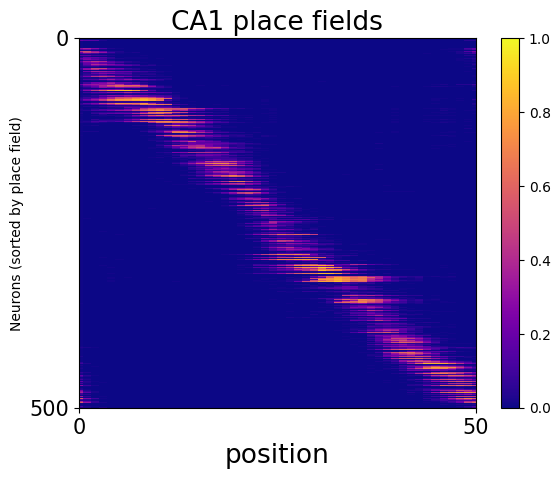

In [40]:
activity_mean = np.mean(activity, axis=0)  
preferential_fields = np.argmax(activity_mean, axis=0)  
sorted_indices = np.argsort(preferential_fields)[::-1]  
sorted_activity = activity_mean[:, sorted_indices] 

fig_e, ax = plt.subplots()

cax = ax.imshow(sorted_activity.T[:500], aspect='auto', 
                cmap='plasma', interpolation='nearest', 
                vmin=0, vmax=1)
fig_e.colorbar(cax, ax=ax)

#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')

# xaxis
ax.set_xticks([0, 49])
ax.set_xticklabels([0, 50], fontsize=15)
ax.set_xlim((0, 49))

# yaxis
ax.set_yticks([0, 499])
ax.set_yticklabels([500, 0], fontsize=15)
ax.set_ylim((0, 499))

# title
ax.set_title(f"CA1 place fields", fontsize=19)
ax.set_xlabel('position', fontsize=19)
plt.show()

In [12]:
from matplotlib.colors import LinearSegmentedColormap

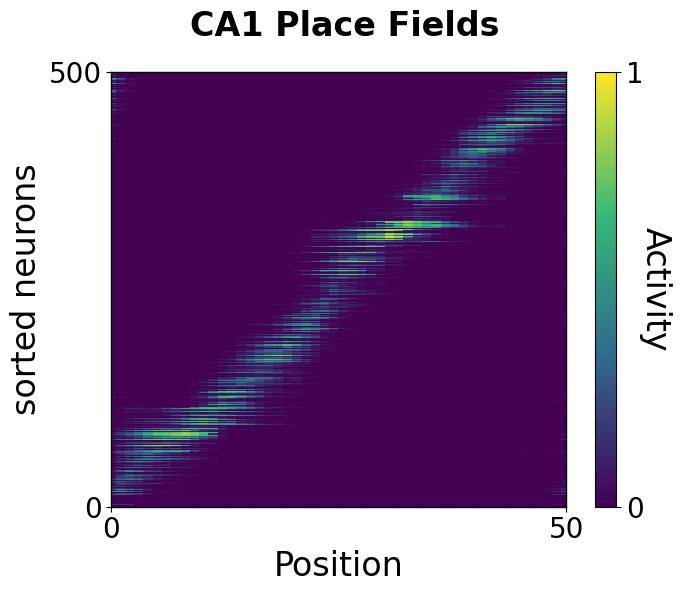

In [41]:
# Set up the figure and axis
fig_e, ax = plt.subplots(figsize=(7, 6))

# Create a custom colormap similar to viridis
colors = ['#440154', '#30678D', '#35B778', '#FDE724']
cmap = LinearSegmentedColormap.from_list('custom_viridis', colors)

# Create the heatmap
cax = ax.imshow(sorted_activity.T[:500], aspect='auto', 
                cmap=cmap, interpolation='nearest', 
                vmin=0, vmax=1.)

# Customize the colorbar
cbar = fig_e.colorbar(cax, ax=ax, ticks=[0, 1])
cbar.set_label('Activity', fontsize=24,
               rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=20)

# Set labels and title
ax.set_ylabel('sorted neurons', fontsize=24)
ax.set_xlabel('Position', fontsize=24)
fig_e.suptitle("CA1 Place Fields", fontsize=24, fontweight='bold')

# Customize x-axis
ax.set_xticks([0, 49])
ax.set_xticklabels([0, 50], fontsize=20)
ax.set_xlim((0, 49))

# Customize y-axis
ax.set_yticks([0, 499])
ax.set_yticklabels([500, 0], fontsize=20)
ax.set_ylim((499, 0))  # Flip the y-axis to have 0 at the top

# Add a grid
ax.grid(True, linestyle=':', alpha=0.7)

# Add a border to the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust layout and display
plt.tight_layout()
plt.show()

#### IS sorting

**IS**

2024-10-14 17:35:00 | (100, 50, 1000)


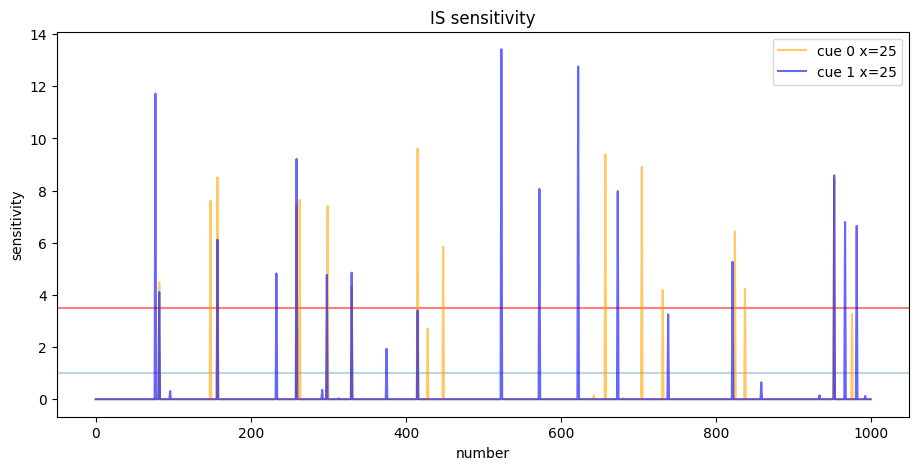

In [77]:
# all activity of IS
K_HIGHEST = 10
is_activity = np.array(model.recordings["IS"]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))
logger(f"{is_activity.shape}")

# plotting
plt.figure(figsize=(11, 5))
plt.axhline(1, alpha=0.3)

plt.axhline(3.5, alpha=0.5, color="red")

# average activity of each neuron
avg_activities = []
is_laps_data = {i: {} for i in range(NUM_CUES)}

colors = ["orange", "blue"]
for k in range(NUM_CUES):
    a_cue = np.mean(is_activity[np.where(lap_cues==k)[0]], axis=0)
    avg_a_cue = a_cue.mean(axis=0)
    cue_pos_ = track_params['cue_position'][k]
    a_cue_pos = a_cue[track_params['cue_position'][k]]
    sensitivity = a_cue_pos / avg_a_cue
    is_laps_data[k]["activity"] = a_cue
    is_laps_data[k]["avg_a"] = avg_a_cue
    is_laps_data[k]["sensitivity"] = sensitivity
    is_laps_data[k]["k-th"] = np.argsort(sensitivity)[-K_HIGHEST:]

    plt.plot(range(network_params["dim_ca1"]), sensitivity, color=colors[k], alpha=0.6,
             label=f"cue {k} x={track_params['cue_position'][k]}")
    #plt.hist(is_laps_data[k]["sensitivity"], bins=10, label=f"cue {k}", alpha=0.2)

plt.xlabel("number")
plt.ylabel("sensitivity")
plt.title("IS sensitivity")
plt.legend()
plt.show()

**CA1**

2024-10-14 17:35:02 | (100, 50, 1000)


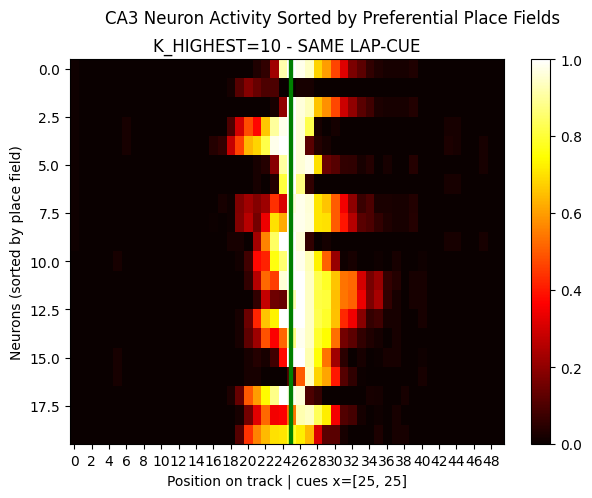

In [78]:
# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{is_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros_like(a_cue)  # (pos, neurons)
for k in range(NUM_CUES):
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    #activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    # select according to IS idxs
    ca1_a[:, K_HIGHEST*k:K_HIGHEST*(k+1)] = activity_cue[:, is_laps_data[k]["k-th"]]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

cax = ax.imshow(ca1_a.T[:K_HIGHEST*NUM_CUES], aspect='auto', cmap='hot', interpolation='nearest', 
          vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - SAME LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

2024-10-14 17:35:05 | (100, 50, 1000)


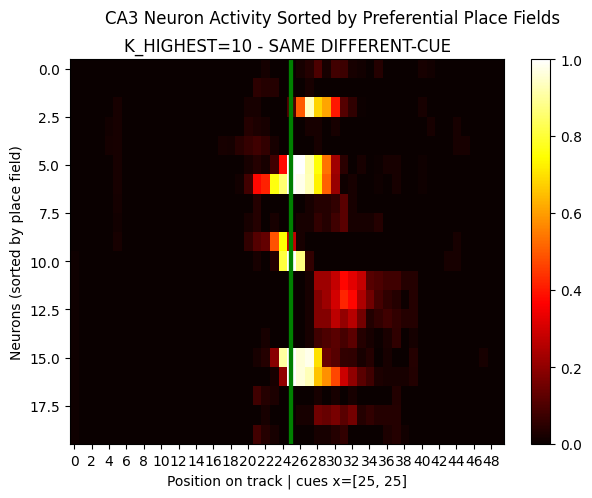

In [79]:
# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{is_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros_like(a_cue)  # (pos, neurons)
for k in range(NUM_CUES):
    #activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    # select according to IS idxs
    ca1_a[:, K_HIGHEST*k:K_HIGHEST*(k+1)] = activity_cue[:, is_laps_data[k]["k-th"]]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

cax =  ax.imshow(ca1_a.T[:K_HIGHEST*NUM_CUES], aspect='auto', cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)

#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - SAME DIFFERENT-CUE")
for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

2024-10-14 17:35:08 | (100, 50, 1000)


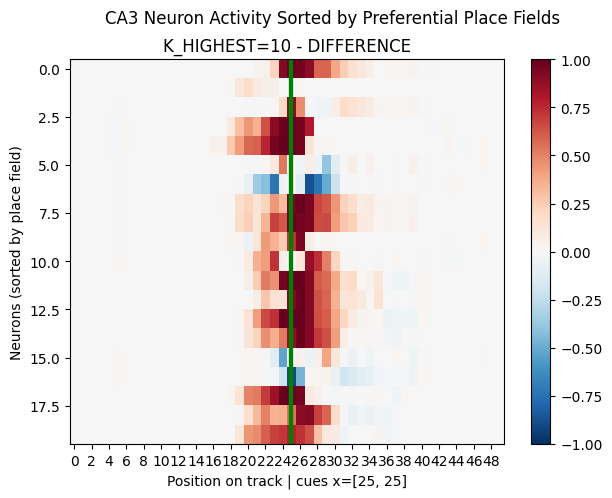

In [80]:
# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{is_activity.shape}")

# average activity of each neuron
ca1_a = np.zeros_like(a_cue)  # (pos, neurons)
for k in range(NUM_CUES):
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    activity_cue_2 = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    # select according to IS idxs
    ca1_a[:, K_HIGHEST*k:K_HIGHEST*(k+1)] = activity_cue[:, is_laps_data[k]["k-th"]] - \
        activity_cue_2[:, is_laps_data[k]["k-th"]]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

cax = ax.imshow(ca1_a.T[:K_HIGHEST*NUM_CUES], aspect='auto', cmap='RdBu_r', interpolation='nearest', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - DIFFERENCE")
for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

#### CA1 sorting

In [54]:
# all activity of IS
K_HIGHEST = 10
NUM_CUES = network_params["num_cues"]

# average activity of each neuron
avg_activities = []
laps_data = {region: {cue : {} for cue in range(NUM_CUES)} for region in model.recordings.keys()}
# {'x_ei': {0: {}, 1: {}}, 'ca1': {0: {}, 1: {}}}
for cue in range(NUM_CUES):
  cue_pos = track_params['cue_position'][cue]
  for region, value in model.recordings.items():
    if region != "W_ca3_ca1":
      activity = np.array(model.recordings[region]).reshape((track_params["num_laps"],
                                                  track_params["length"], -1))
      activity_av_laps_positions = np.mean(activity, axis=(0, 1))
      activity_av_when_cue = np.mean(activity[np.where(lap_cues==cue)[0]], axis=0)
      sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
      laps_data[region][cue]["activity"] = activity_av_when_cue
      laps_data[region][cue]["sensitivity"] = sensitivity
      laps_data[region][cue]["k-th"] = np.argsort(sensitivity)[-K_HIGHEST:] # [..]


neurons_cue_1_position_1 = np.argsort(laps_data["IS"][0]["activity"][track_params["cue_position"][0]])[-K_HIGHEST:]
neurons_cue_2_position_1 = np.argsort(laps_data["IS"][1]["activity"][track_params["cue_position"][0]])[-K_HIGHEST:]
neurons_cue_1_position_2 = np.argsort(laps_data["IS"][0]["activity"][track_params["cue_position"][1]])[-K_HIGHEST:]
neurons_cue_2_position_2 = np.argsort(laps_data["IS"][1]["activity"][track_params["cue_position"][1]])[-K_HIGHEST:]

neurons_cue_1 = neurons_cue_1_position_1[~np.isin(neurons_cue_1_position_1, neurons_cue_2_position_1)]
neurons_cue_2 = neurons_cue_2_position_2[~np.isin(neurons_cue_2_position_2, neurons_cue_1_position_2)]

selective_neurons = np.concatenate((neurons_cue_1, neurons_cue_2))

logger

/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_69470/2770219949.py:17: RuntimeWarning: divide by zero encountered in divide
  sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_69470/2770219949.py:17: RuntimeWarning: invalid value encountered in divide
  sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
2024-10-15 22:20:04 | .


In [39]:
print(neurons_cue_1, neurons_cue_2)



[727 549 190 110 760 414 705] [615 103 891 863 982 684 536 882]


2024-10-15 22:20:07 | (100, 50, 1000)


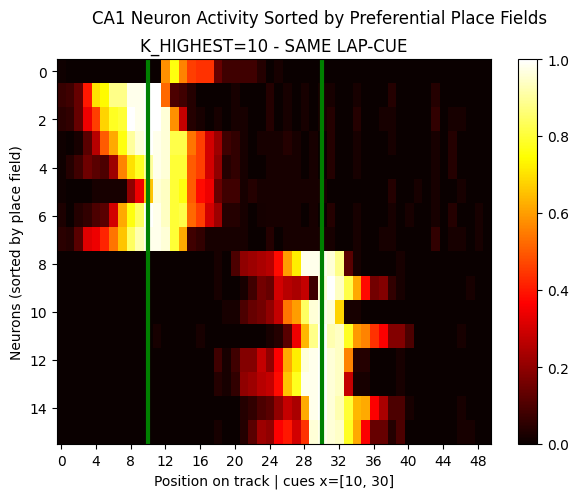

In [55]:
""" POSITION-a CUE-a """

# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{ca1_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros((network_params["mec_N_x"], network_params["dim_ca1"]))  # (pos, neurons)
for k in range(NUM_CUES):
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]],
                           axis=0)
    #activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    index_neurons = neurons_cue_1 if k == 0 else neurons_cue_2
    
    # select according to IS idxs
    ca1_a[:, len(index_neurons)*k: len(index_neurons)*(k+1)] = activity_cue[:, index_neurons]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'CA1 Neuron Activity Sorted by Preferential Place Fields')

cax = ax.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', cmap='hot', interpolation='nearest', 
          vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
h=4
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - SAME LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

2024-10-15 22:20:15 | (100, 50, 1000)


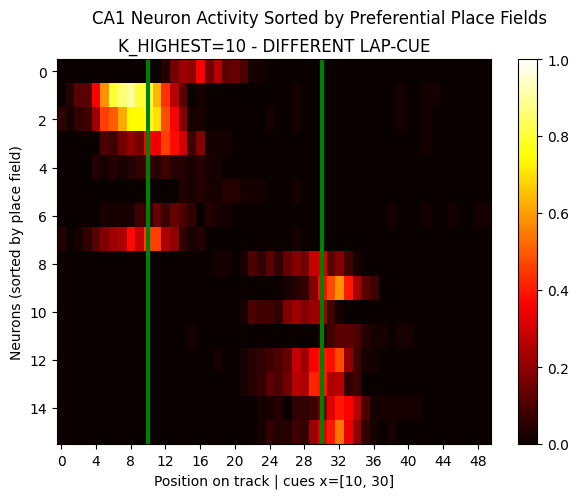

In [56]:
""" POSITION-a CUE-b """

# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{ca1_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros((network_params["mec_N_x"], network_params["dim_ca1"]))  # (pos, neurons)
for k in range(NUM_CUES):
    #activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    index_neurons = neurons_cue_1 if k == 0 else neurons_cue_2
    
    # select according to IS idxs
    ca1_a[:, len(index_neurons)*k: len(index_neurons)*(k+1)] = activity_cue[:, index_neurons]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'CA1 Neuron Activity Sorted by Preferential Place Fields')

cax = ax.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', 
                cmap='hot', interpolation='nearest', 
          vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
h=4
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - DIFFERENT LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

2024-10-15 22:20:17 | (100, 50, 1000)


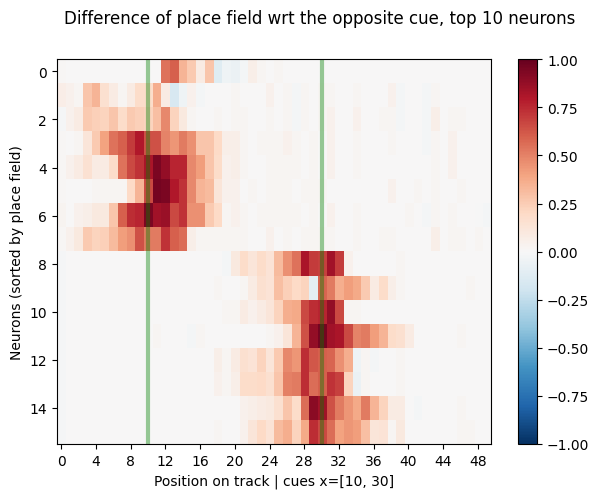

In [57]:
""" DIFFERENCE """

# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{ca1_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros((network_params["mec_N_x"], network_params["dim_ca1"]))  # (pos, neurons)
for k in range(NUM_CUES):
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    activity_cue_2 = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    # select according to IS idxs
    #ca1_a[:, K_HIGHEST*k:K_HIGHEST*(k+1)] = activity_cue[:, is_laps_data[k]["k-th"]] - \
    #    activity_cue_2[:, is_laps_data[k]["k-th"]]

    index_neurons = neurons_cue_1 if k == 0 else neurons_cue_2
    
    # select according to IS idxs
    ca1_a[:, len(index_neurons)*k: len(index_neurons)*(k+1)] = activity_cue[:, index_neurons] - \
        activity_cue_2[:, index_neurons]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'Difference of place field wrt the opposite cue, top {K_HIGHEST} neurons')

cax = ax.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', cmap='RdBu_r', interpolation='nearest', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
h=4
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
#ax.set_title(f"K={K_HIGHEST=} - DIFFERENCE LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3, alpha=0.4)
plt.show()

#### Plots for figure
---

**Plot e**

In [15]:
""" settings """
labsize = 34
titlesize = 34
ticksize = 24

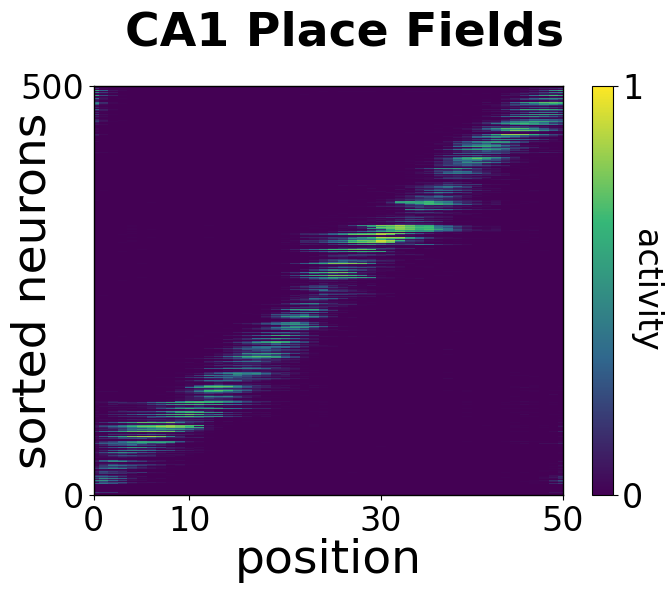

In [42]:
# Set up the figure and axis
fig_e, ax_e = plt.subplots(figsize=(7, 6))

# Create a custom colormap similar to viridis
colors = ['#440154', '#30678D', '#35B778', '#FDE724']
cmap = LinearSegmentedColormap.from_list('custom_viridis', colors)

# Create the heatmap
cax_e = ax_e.imshow(sorted_activity.T[:500], aspect='auto', 
                cmap=cmap, interpolation='nearest', 
                vmin=0, vmax=1)

# Customize the colorbar
cbar_e = fig_e.colorbar(cax_e, ax=ax_e, ticks=[0, 1])
cbar_e.set_label('activity', fontsize=24,
               rotation=270, labelpad=13)
cbar_e.ax.tick_params(labelsize=ticksize)

# Set labels and title
ax_e.set_ylabel('sorted neurons', fontsize=labsize, labelpad=-25)
ax_e.set_xlabel('position', fontsize=labsize,labelpad=0)
fig_e.suptitle("CA1 Place Fields", fontsize=titlesize, fontweight='bold')

# Customize x-axis
ax_e.set_xticks([0, track_params['cue_position'][0],
                 track_params['cue_position'][1], 49])
ax_e.set_xticklabels([0, track_params['cue_position'][0],
                      track_params['cue_position'][1], 50], fontsize=ticksize)
ax_e.set_xlim((0, 49))

# Customize y-axis
ax_e.set_yticks([0, 499])
ax_e.set_yticklabels([500, 0], fontsize=ticksize)
ax_e.set_ylim((499, 0))  # Flip the y-axis to have 0 at the top

# Add a grid
#ax_e.grid(True, linestyle=':', alpha=0.7)

# Add a border to the plot
for spine in ax_e.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust layout and display
plt.tight_layout()
plt.show()

**Plot f**

In [48]:
len(neurons_cue_2)

8

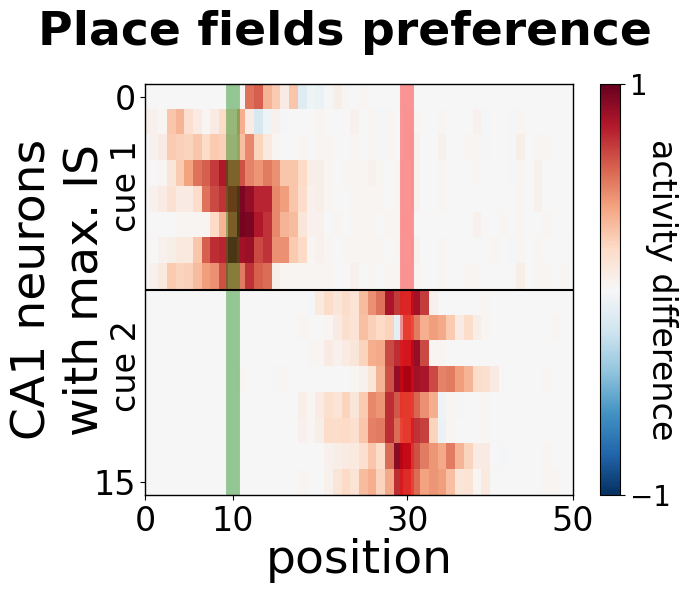

In [66]:
fig_f, ax_f = plt.subplots(figsize=(7, 6))

cax_f = ax_f.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', cmap='RdBu_r', 
               interpolation='nearest', vmin=-1, vmax=1)

# colorbar
cbar_f = fig_f.colorbar(cax_f, ax=ax_f, ticks=[-1, 1])
cbar_f.set_label('activity difference', fontsize=24,
               rotation=270, labelpad=5)
cbar_f.ax.tick_params(labelsize=20)

# labels & title
#ax_f.set_ylabel(f'top selective\nneurons', fontsize=labsize, labelpad=-20)
ax_f.set_ylabel(f'CA1 neurons\nwith max. IS', fontsize=labsize, labelpad=-10)
ax_f.set_xlabel(f"position", fontsize=labsize, labelpad=0)
fig_f.suptitle("Place fields preference", fontsize=titlesize, fontweight='bold')

# Customize x-axis
ax_f.set_xticks([0, track_params['cue_position'][0],
                 track_params['cue_position'][1], 49])
ax_f.set_xticklabels([0, track_params['cue_position'][0],
                      track_params['cue_position'][1], 50], fontsize=ticksize)
ax_f.set_xlim((0, 49))

# Customize y-axis
ax_f.set_yticks([0, 15])
ax_f.set_yticklabels([0, 15], fontsize=ticksize)
ax_f.set_ylim((15.5, -0.5))

# identification lines
ax_f.axvline(track_params['cue_position'][0], color="green", lw=10, alpha=0.4)
ax_f.axvline(track_params['cue_position'][1], color="red", lw=10, alpha=0.4)
ax_f.axhline(7.5, color="black")

#
ax_f.text(-4, 5, f"cue 1", rotation=90, fontsize=24)
ax_f.text(-4, 12, f"cue 2", rotation=90, fontsize=24)


# Add a border to the plot
for spine in ax_f.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

#ax.text(0.5, -0.20, f"Cues at x={track_params['cue_position']}", 
#        horizontalalignment='center', verticalalignment='top', 
#        transform=ax.transAxes, fontsize=15)

plt.tight_layout()
plt.show()

In [35]:
fig_f.savefig(f"{utils.MEDIA_PATH}/figure_f.svg")
logger("saved")

NameError: name 'fig_f' is not defined

In [43]:
fig_e.savefig(f"{utils.MEDIA_PATH}/figure_e.svg")
logger("saved")

2024-10-15 22:43:46 | saved


### other

---

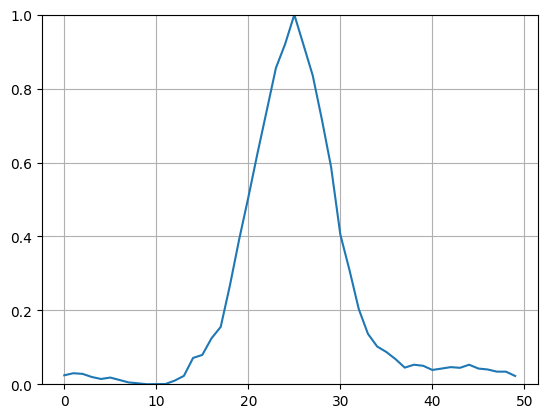

In [32]:
""" pattern similarity """

def get_cos_sim(arr1, arr2):
    return np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))

get_cos_sim(arr1=laps_data["IS"][0]["activity"][25],
            arr2=laps_data["IS"][0]["activity"][25])

plt.plot([get_cos_sim(arr1=laps_data["IS"][0]["activity"][25],
            arr2=laps_data["IS"][0]["activity"][i]) for i in range(50)])
plt.ylim((0, 1))
plt.grid();

---

In [382]:
# all activity of IS
K_HIGHEST = 10


NUM_CUES = network_params["num_cues"]
# average activity of each neuron
avg_activities = []
laps_data = {region: {cue : {} for cue in range(NUM_CUES)} for region in model.recordings.keys()}

for cue in range(NUM_CUES):
  cue_pos = track_params['cue_position'][cue]
  for region, value in model.recordings.items():
    if region != "W_ca3_ca1":
      activity = np.array(model.recordings[region]).reshape((track_params["num_laps"],
                                                  track_params["length"], -1))
      activity_av_laps_positions = np.mean(activity, axis=(0, 1))
      activity_av_when_cue = np.mean(activity[np.where(lap_cues==cue)[0]], axis=0)
      sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
      laps_data[region][cue]["activity"] = activity_av_when_cue
      laps_data[region][cue]["sensitivity"] = sensitivity
      laps_data[region][cue]["k-th"] = np.argsort(sensitivity)[-K_HIGHEST:]

logger

2024-10-13 21:48:20 | .


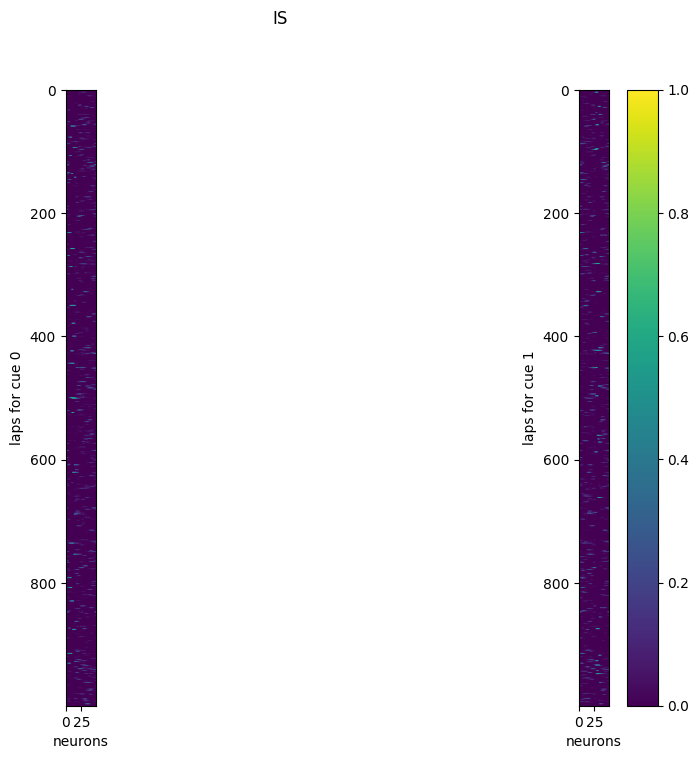

In [383]:
region = "IS"


# Step 4: Plot the heatmap
fig, axs = plt.subplots(1, network_params["num_cues"],
                      figsize=(10, 8),
                      sharex=True)
plt.suptitle(f'{region.upper()}')

all_selective_index = np.concatenate((laps_data[region][0]["k-th"], laps_data[region][1]["k-th"]))
for cue, ax in enumerate(axs):
    #activity = laps_data[region][cue]["activity"]
    #activity = laps_data[region][cue]["activity"][:, all_selective_index]
    activity = laps_data[region][cue]["activity"]
    #ca3_a = activity[np.where(lap_cues==k)[0]][:, track_params['cue_position'][k],:]
    imshow = ax.imshow(activity.T)
    #ax.imshow(ca3_a, aspect="auto")
    #ax.set_title(f"cue {k}")
    ax.set_xlabel("neurons")
    ax.set_ylabel(f"laps for cue {cue}")

fig.colorbar(imshow, ax=ax)
plt.show()

In [ ]:
# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{is_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros_like(a_cue)  # (pos, neurons)
k=1

# 
activity_cue = np.mean(ca1_activity[np.where(lap_cues==0)[0]], axis=0)
#activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

# select according to IS idxs
ca1_a[:, :K_HIGHEST] = activity_cue[:, is_laps_data[0]["k-th"]]

ca1_a[:, K_HIGHEST*1:K_HIGHEST*2] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
_, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'CA1 Neuron Activity Sorted by Preferential Place Fields')

ax.imshow(ca1_a.T[:K_HIGHEST*NUM_CUES], aspect='auto', cmap='hot', 
          interpolation='nearest', vmin=0, vmax=1)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=}")
plt.show()

---

In [501]:
track_params['cue_position'][k]

10

In [503]:
ca3_a[:, track_params['cue_position'][k], :].shape

(51, 100)

In [511]:
np.where(lap_cues==k)

(array([ 3,  4,  5,  8, 10, 11, 12, 13, 14, 18, 19, 23, 24, 25, 27, 28, 29,
        30, 31, 34, 36, 38, 43, 45, 47, 49, 50, 52, 58, 59, 60, 62, 64, 65,
        69, 71, 72, 74, 75, 76, 77, 78, 79, 81, 83, 84, 89, 90, 92, 98, 99]),)

In [512]:
ca3_a[np.where(lap_cues==k)[0]][:, track_params['cue_position'][k],:].shape

(51, 100)

In [28]:
is_laps_data[k]["k-th"], ca3_activity.shape


(array([18, 61, 72, 86]), (100, 50, 100))

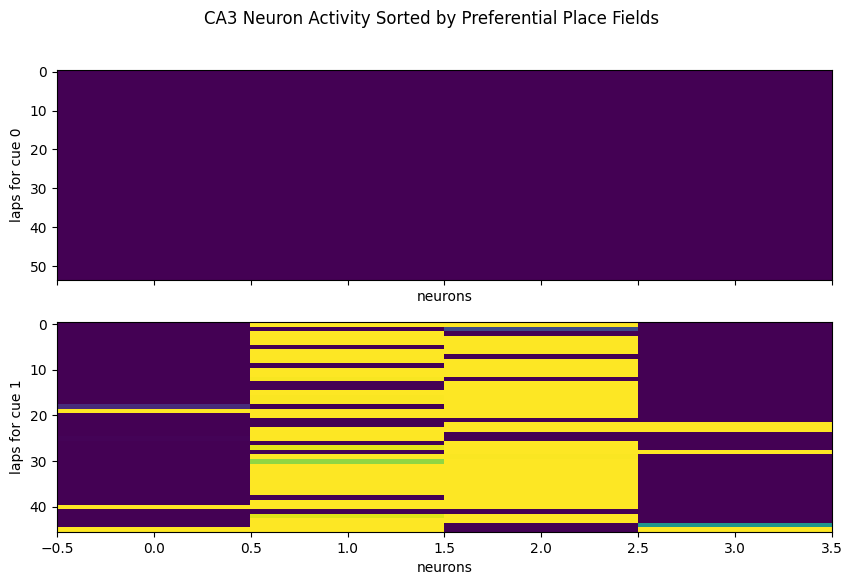

In [50]:
ca3_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))


activity = ca3_activity[:, :, is_laps_data[1]["k-th"]]
#activity[:, :, is_laps_data[0]["k-th"]] = ca3_activity[:, :, is_laps_data[0]["k-th"]]
#activity[:, :, ~is_laps_data[0]["k-th"]] = 0

# Step 4: Plot the heatmap
_, axs = plt.subplots(network_params["num_cues"], 1, 
                      figsize=(10, 3*network_params["num_cues"]),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

for k, ax in enumerate(axs):
    ca3_a = activity[np.where(lap_cues==k)[0]][:, track_params['cue_position'][k],:]

    ax.imshow(ca3_a, aspect="auto")
    #ax.set_title(f"cue {k}")
    ax.set_xlabel("neurons")
    ax.set_ylabel(f"laps for cue {k}")

plt.show()

In [52]:
np.where(lap_cues==0)[0]

array([ 1,  3,  4,  8,  9, 10, 12, 13, 16, 17, 19, 20, 22, 24, 25, 27, 29,
       30, 33, 37, 38, 39, 40, 41, 43, 44, 47, 50, 51, 53, 54, 55, 56, 58,
       59, 61, 62, 66, 67, 69, 71, 76, 80, 81, 82, 84, 86, 87, 90, 91, 92,
       95, 96, 97])

In [53]:
lap_cues

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])

2024-10-12 19:14:16 | (100, 50, 100)


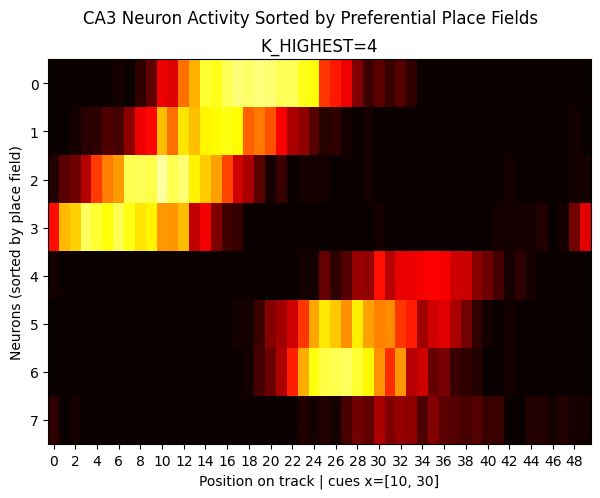

In [51]:
# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{is_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros_like(a_cue)  # (pos, neurons)
k=1

# 
activity_cue = np.mean(ca1_activity[np.where(lap_cues==0)[0]], axis=0)
#activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

# select according to IS idxs
ca1_a[:, :K_HIGHEST] = activity_cue[:, is_laps_data[0]["k-th"]]

ca1_a[:, K_HIGHEST*1:K_HIGHEST*2] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
_, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

ax.imshow(ca1_a.T[:K_HIGHEST*NUM_CUES], aspect='auto', cmap='hot', 
          interpolation='nearest', vmin=0, vmax=1)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=}")
plt.show()

#### Plotting

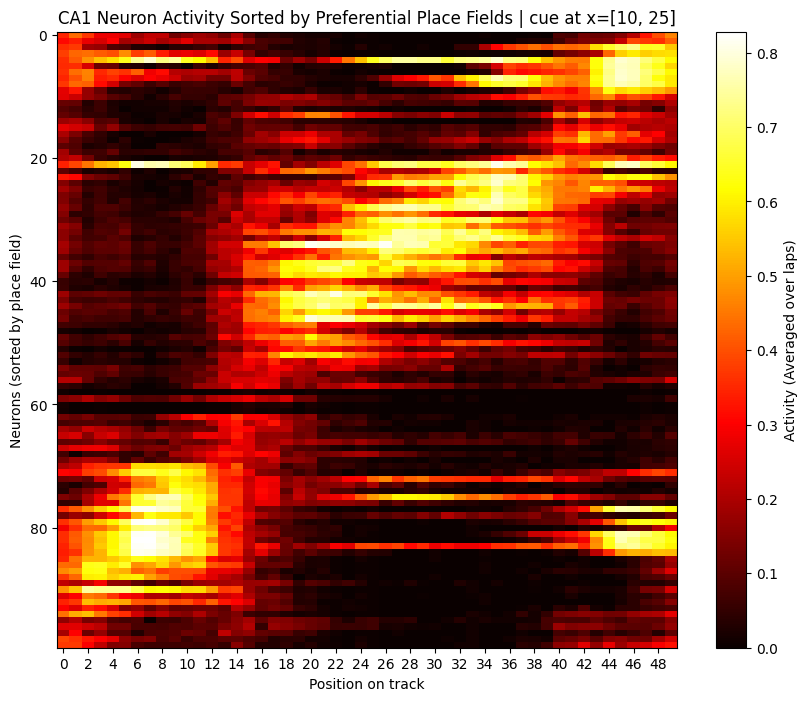

In [120]:
name="ca1"

activity = np.array(model.recordings[name]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))

# Assuming 'activity' is a 3D array of shape (laps, positions, neurons)
# activity.shape = (n_laps, n_positions, n_neurons)

# Step 1: Average across laps (axis 0)
activity_mean = np.mean(activity, axis=0)  # Now shape is (positions, neurons)

# Step 2: Find preferential place field (position with max activity) for each neuron
preferential_fields = np.argmax(activity_mean, axis=0)  # Finds the max position for each neuron

# Step 3: Sort neurons by preferential place fields in descending order
sorted_indices = np.argsort(preferential_fields)[::-1]  # Sort in descending order of place fields
sorted_activity = activity_mean[:, sorted_indices]  # Reorder neurons by sorted indices

# Step 4: Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(sorted_activity.T, aspect='auto', cmap='hot', interpolation='nearest', vmin=0)
plt.colorbar(label='Activity (Averaged over laps)')
plt.ylabel('Neurons (sorted by place field)')
plt.xlabel('Position on track')
h=2
plt.xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
plt.title(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields | cue at x={track_params["cue_position"]}')
plt.show()


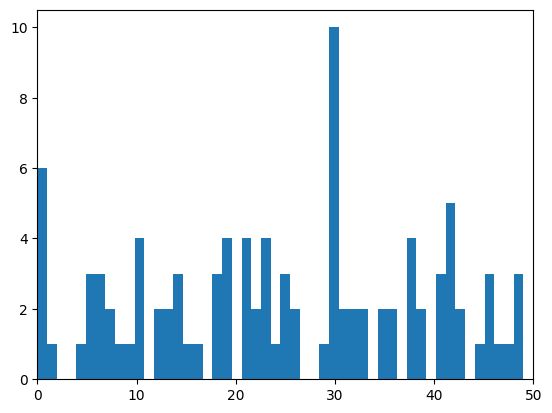

In [20]:
plt.hist(preferential_fields.flatten(), bins=50)
plt.xlim([0, 50])
plt.show()

In [333]:
activity[lap_cues.astype(bool)].shape

(46, 50, 100)

In [351]:
activity[np.where(lap_cues==0R)[0]].shape

(54, 50, 100)

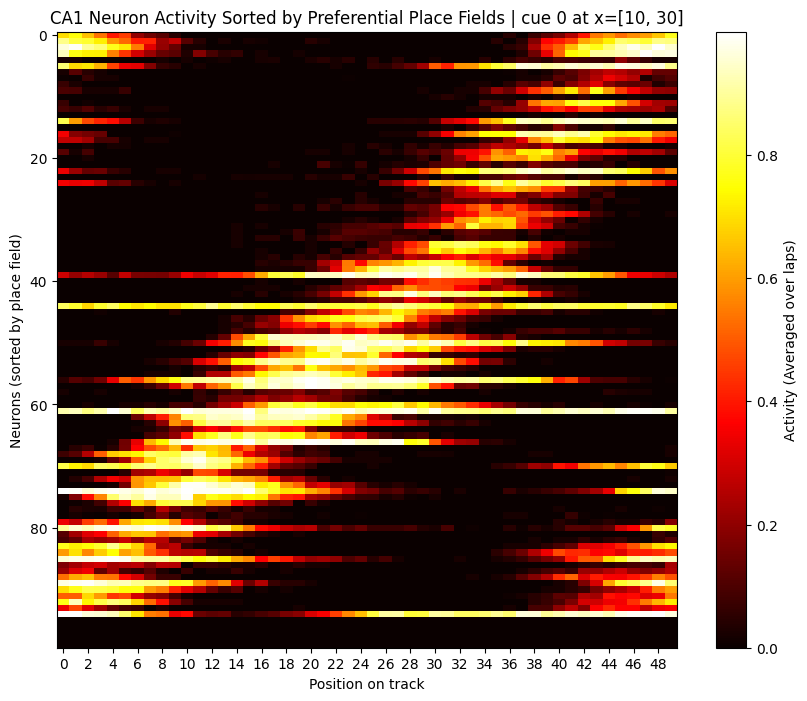

In [14]:
""" plot """
name="ca1"
cue_index = 0

activity = np.array(model.recordings[name]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))


# Assuming 'activity' is a 3D array of shape (laps, positions, neurons)
# activity.shape = (n_laps, n_positions, n_neurons)

# Step 1: Average across laps (axis 0) for a given cue
activity_mean = np.mean(activity[np.where(lap_cues==cue_index)[0]], axis=0)  # Now shape is (positions, neurons)

# Step 2: Find preferential place field (position with max activity) for each neuron
preferential_fields = np.argmax(activity_mean, axis=0)  # Finds the max position for each neuron


# Step 3: Sort neurons by preferential place fields in descending order
sorted_indices = np.argsort(preferential_fields)[::-1]  # Sort in descending order of place fields
sorted_activity = activity_mean[:, sorted_indices]  # Reorder neurons by sorted indices

# Step 4: Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(sorted_activity.T, aspect='auto', cmap='hot', interpolation='nearest', vmin=0)
plt.colorbar(label='Activity (Averaged over laps)')
plt.ylabel('Neurons (sorted by place field)')
plt.xlabel('Position on track')
h=2
plt.xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
plt.title(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields | cue {cue_index} at x={track_params["cue_position"]}')
plt.show()


In [326]:

# Step 3: Sort neurons by preferential place fields in descending order
sorted_indices = np.argsort(preferential_fields)[::-1]  # Sort in descending order of place fields
sorted_activity = activity_mean[:, sorted_indices]  # Reorder neurons by sorted indices

# Step 4: Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(sorted_activity.T, aspect='auto', cmap='hot', interpolation='nearest', vmin=0)
plt.colorbar(label='Activity (Averaged over laps)')
plt.ylabel('Neurons (sorted by place field)')
plt.xlabel('Position on track')
h=2
plt.xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
plt.title(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields | cue at x={track_params["cue_position"]}')
plt.show()


array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])

---

In [4]:
def sparse_stimulus_generator_sensory(num_stimuli: int, K : int,
                                      mec_size: int,  lec_size: int,
                                      N_x : int, N_y : int,
                                      pf_sigma: int,
                                      num_laps: int,
                                      lap_length: int=None,
                                      num_cues: int=None,
                                      position_list=None,
                                      cue_positions=None,
                                      sen_list=None,
                                      plot: bool=False) -> np.ndarray:

    """
    This function generates random z patterns with a certain
    degree of sparsity

    Parameters
    ----------
    N : int
        Number of samples
    K : int
        Number of active units
    size : int, optional
        Size of the z patterns, by default 10
    plot : bool, optional
        Whether to plot the z patterns.
        Default False

    Returns
    -------
    samples : np.ndarray
        z patterns
    """

    def place_field_activity(N_x, N_y, sigma, xi, yi):
        """
        Computes place field activity for each cell on an NxN grid for a given location (xi, yi).
        """

        def circular_distance(x1, x2, N):
            """
            Computes the minimum circular distance in the x-direction (wraps around the boundaries).
            """
            return np.minimum(np.abs(x1 - x2), N - np.abs(x1 - x2))

        # Create a grid of size NxN with place cells at each position
        x = np.linspace(0, N_x-1, N_x)
        y = np.linspace(0, N_y-1, N_y)
        X, Y = np.meshgrid(x, y)
        # Calculate the squared Euclidean distance between (xi, yi) and each place cell location
        dist_squared = circular_distance(X, xi, N_x) ** 2 + (Y - yi) ** 2

        # Compute Gaussian activity for each place cell
        activity = np.exp(-dist_squared / (2 * sigma ** 2))
        return activity

    def place_tuning(x, c, sigma):
        return np.exp(-((x - c) ** 2) / (2 * sigma ** 2))

    samples = np.zeros((num_stimuli, mec_size + lec_size))

    if lec_size > 0 and num_cues is not None:
        fixed_cue = np.zeros((num_cues, lec_size))
        for k in range(num_cues):
            cue_idx = np.random.choice(range(lec_size), replace=False, size=K)
            fixed_cue[k, cue_idx] = 1


    # 0, 0, 1, 0, 1, 1...
    lap_cues = np.random.choice(range(num_cues), size=num_laps) if num_laps is not None else None
    """
    [0, 1, 3, 4.. 10, 0, 1, 3, ...10]
    """
    for i in range(num_stimuli): # laps x length

        lap_idx = i // lap_length

        if mec_size > 0:
            x_i, y_i = (position_list[i] if position_list is not None \
                                else (np.random.randint(0, N_x), np.random.randint(0, N_y)))
            activity_grid = place_field_activity(N_x, N_y, pf_sigma, x_i, y_i)
            samples[i, :mec_size] = activity_grid.flatten()

        if lec_size > 0:
            if cue_positions is not None:

                if x_i == cue_positions[lap_cues[lap_idx]]:
                    activity_lec = fixed_cue[lap_cues[lap_idx]]
                else:
                    activity_lec = np.zeros((lec_size))
                    lec_idx = np.random.choice(range(lec_size),
                                               replace=False, size=K)
                    activity_lec[lec_idx] = 1

                samples[i, mec_size:] = sen_list[i] if sen_list is not None else activity_lec

    samples = samples.astype(np.float32)

    return samples, lap_cues

def get_track_input(tp: dict, network_params: dict):
    
  position_list = [(x, 0) for lap in range(tp["num_laps"]) for x in range(tp["length"])]

  if tp["reward"] == "random":
    reward_list = None
  if tp["cue"] == "random":
    cue_list = None

  sen_list = None

  track_input, lap_cues = sparse_stimulus_generator_sensory(num_stimuli=tp["num_laps"]*tp["length"],
                                                  K = network_params["K_lec"],
                                                  mec_size=network_params["dim_mec"],
                                                  lec_size=network_params["dim_lec"],
                                                  N_x=network_params["mec_N_x"],
                                                  N_y=network_params["mec_N_y"],
                                                  pf_sigma=network_params["mec_sigma"],
                                                  lap_length=track_params["length"],
                                                  num_laps=track_params["num_laps"],
                                                  num_cues=network_params["num_cues"],
                                                  position_list=position_list,
                                                  cue_positions=tp["cue_position"],
                                                  sen_list=None,
                                                  plot=False)
  return track_input, lap_cues



In [283]:
230 // 100

2

In [103]:
test_samples = sparse_stimulus_generator_sensory(num_stimuli=num_test_stimuli,
                                                K = network_params["K_lec"],
                                                mec_size=network_params["dim_mec"],
                                                lec_size=network_params["dim_lec"],
                                                N_x=network_params["mec_N_x"],
                                                N_y=network_params["mec_N_y"],
                                                pf_sigma=network_params["mec_sigma"],
                                                num_cues=network_params["num_cues"],
                                                position_list=None,
                                                cue_positions=[5, 45],
                                                sen_list=None,
                                                plot=False)

/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_30323/2933058906.py:77: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  cue_i = np.where(x_i == cue_positions)[0]
